In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


figsize=(9, 3)


In [3]:

energy_df = pd.read_csv('../energy_dataset.csv')
weather_df = pd.read_csv('../weather_features.csv')
energy_df.fillna(0, inplace=True)
weather_df.fillna(0, inplace=True)

# Convert the 'time' columns to datetime and set as index
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, errors='coerce')
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, errors='coerce')

In [4]:
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')
data.set_index('time', inplace=True)
data.head()
data.index = pd.to_datetime(data.index)
# Check if 'city_name' and 'price actual' are available
print(data.columns)
data.fillna(0, inplace=True)
data.sort_index(inplace=True)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed

In [21]:
codes_bt = data.copy()
codes_bt['month'] = codes_bt.index.month
codes_bt['weekday'] = codes_bt.index.weekday
codes_bt['hour'] = codes_bt.index.hour
# the years after 2014:
codes_bt['year'] = codes_bt.index.year
codes_bt = codes_bt[codes_bt['year'] > 2014]


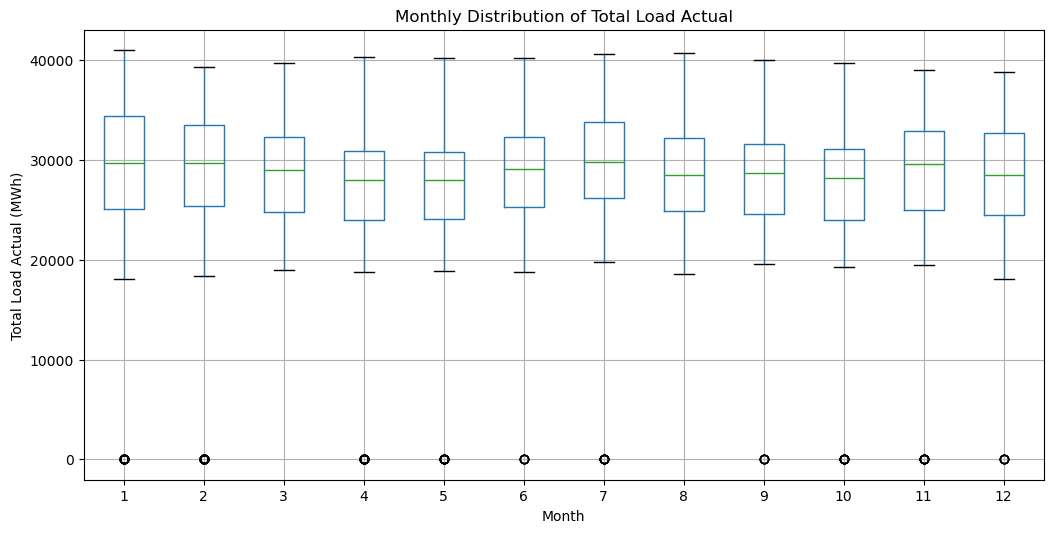

In [6]:
data_boxplot = codes_bt[['month', 'total load actual']].boxplot(
    by='month',
    figsize=(12, 6)
)

plt.title('Monthly Distribution of Total Load Actual')
plt.suptitle('')  # This removes the automatic 'Boxplot grouped by month' title
plt.xlabel('Month')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

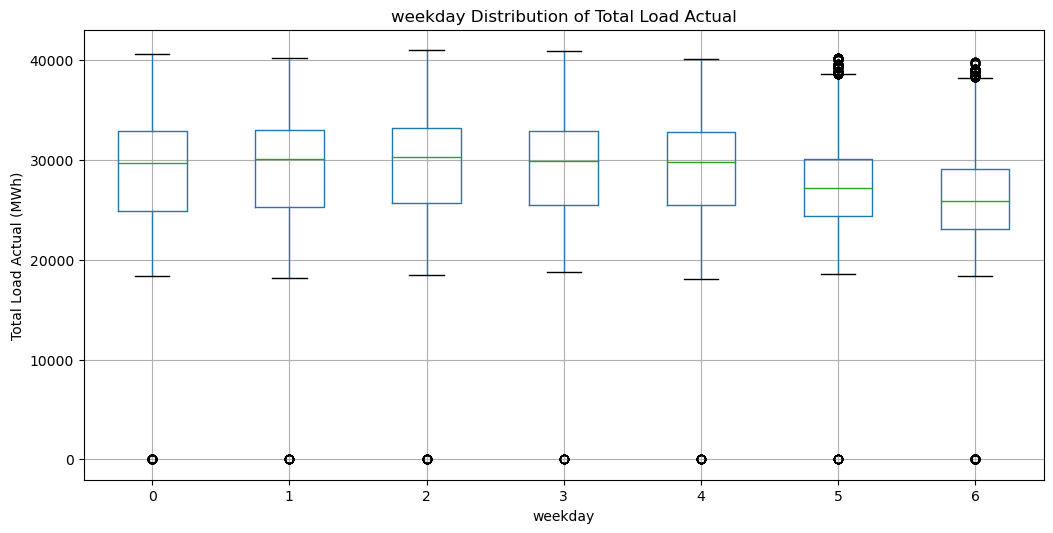

In [7]:

data_boxplot = codes_bt[['weekday', 'total load actual']].boxplot(
    by='weekday',
    figsize=(12, 6)
)

plt.title('weekday Distribution of Total Load Actual')
plt.suptitle('')  # This removes the automatic 'Boxplot grouped by month' title
plt.xlabel('weekday')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

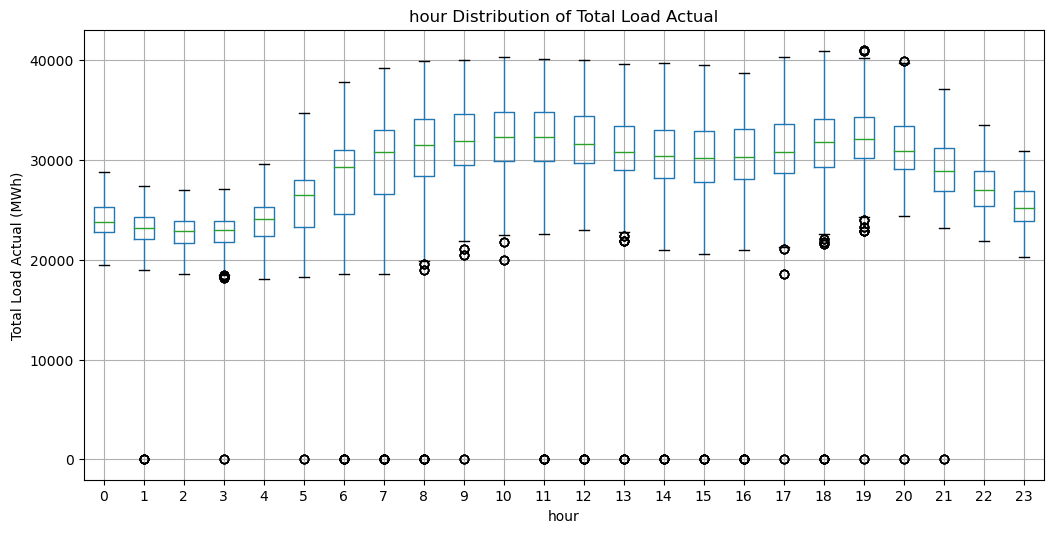

In [18]:

data_boxplot = codes_bt[['hour', 'total load actual']].boxplot(
    by='hour',
    figsize=(12, 6)
)

plt.title('hour Distribution of Total Load Actual')
plt.suptitle('')  # This removes the automatic 'Boxplot grouped by month' title
plt.xlabel('hour')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

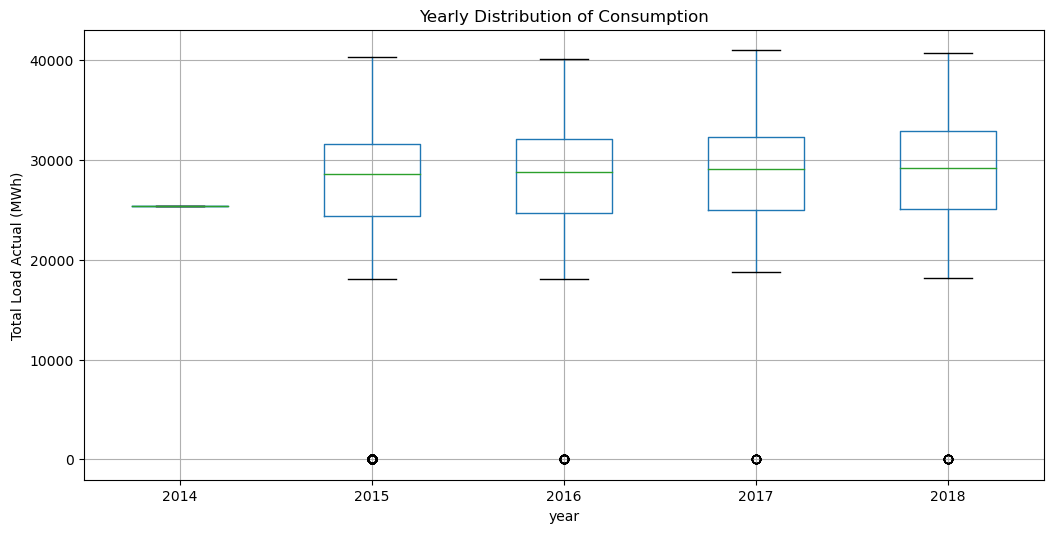

In [22]:

data_boxplot = codes_bt[['year', 'total load actual']].boxplot(
    by='year',
    figsize=(12, 6)
)

plt.title('Yearly Distribution of Consumption')
plt.suptitle('')  
plt.xlabel('year')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

In [19]:
# Group data by city and resample to get annual averages
data['year'] = data.index.year
data['city_name'] = data.city_name
city_yearly_load = data.groupby(['city_name', 'year'])['total load actual'].mean().reset_index()
city_yearly_price = data.groupby(['city_name', 'year'])['price actual'].mean().reset_index()



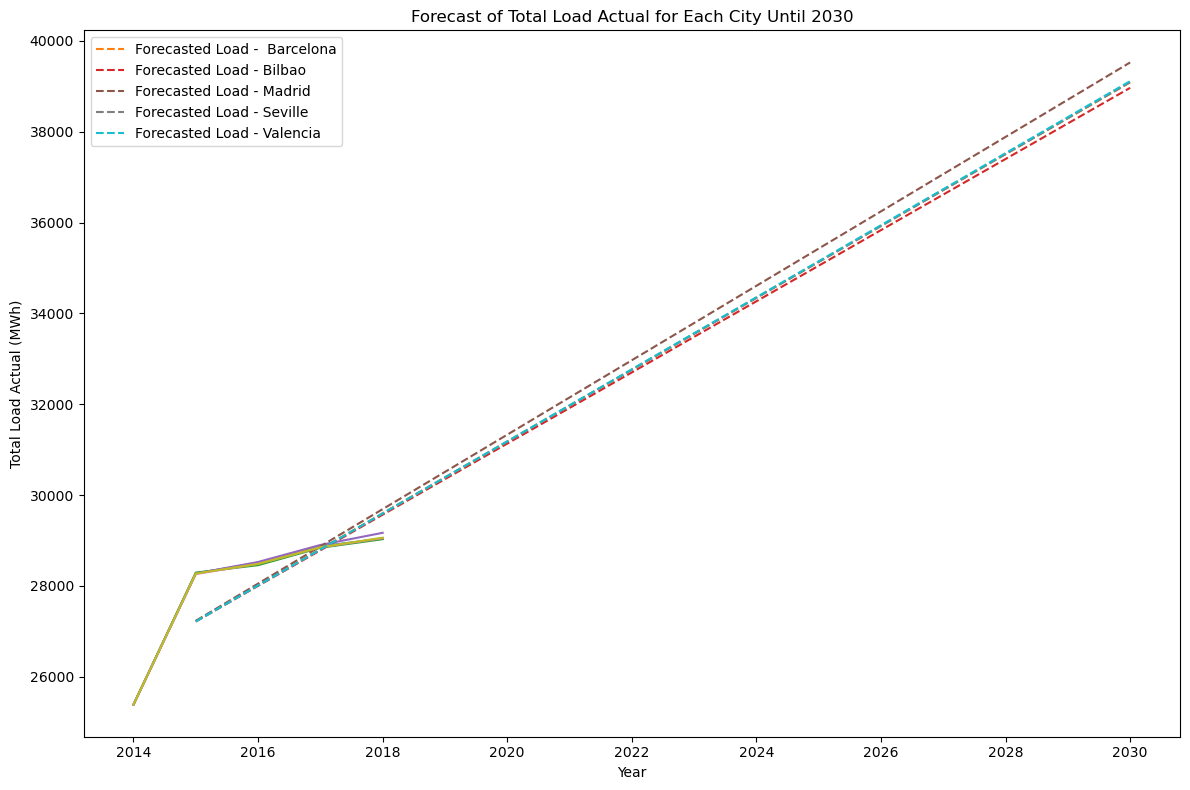

In [20]:

# Plot and forecast for each city in the same graph
plt.figure(figsize=(12, 8))

for city in city_yearly_load['city_name'].unique():
    city_data = city_yearly_load[city_yearly_load['city_name'] == city]
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model
    X = city_data[['year']]
    y = city_data['total load actual']
    model.fit(X, y)
    
    # Create future years for prediction
    future_years = pd.DataFrame({'year': range(2015, 2031)})
    
    # Predict
    future_load = model.predict(future_years)
    
    # Plot historical load
    plt.plot(city_data['year'], city_data['total load actual'])
    
    # Plot forecasted load
    plt.plot(future_years['year'], future_load, linestyle='--', label=f'Forecasted Load - {city}')

plt.title('Forecast of Total Load Actual for Each City Until 2030')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.legend()
plt.tight_layout()  # Adjust layout to fit all legends
plt.show()

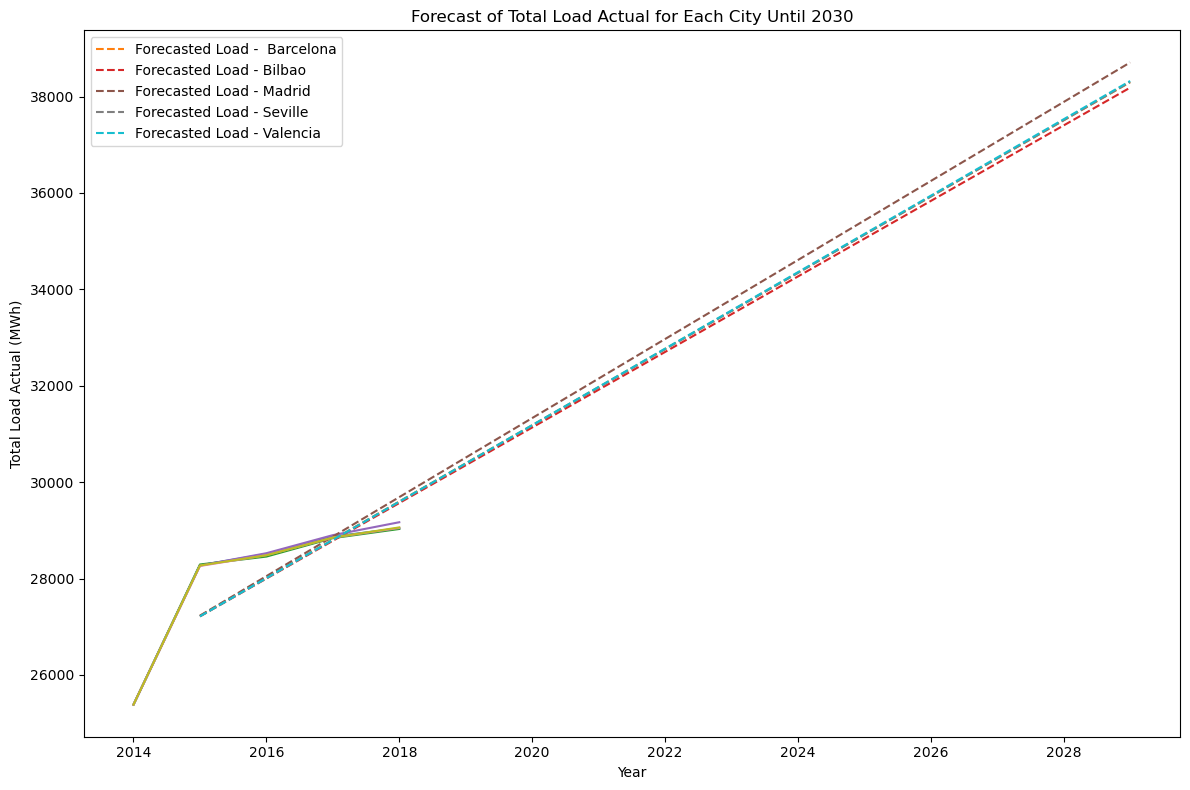

In [21]:

# Plot and forecast for each city in the same graph
plt.figure(figsize=(12, 8))

for city in city_yearly_load['city_name'].unique():
    city_data = city_yearly_load[city_yearly_load['city_name'] == city]
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model
    X = city_data[['year']]
    y = city_data['total load actual']
    model.fit(X, y)
    
    # Create future years for prediction
    future_years = pd.DataFrame({'year': range(2015, 2030)})
    
    # Predict
    future_load = model.predict(future_years)
    
    # Plot historical load
    plt.plot(city_data['year'], city_data['total load actual'])
    
    # Plot forecasted load
    plt.plot(future_years['year'], future_load, linestyle='--', label=f'Forecasted Load - {city}')

plt.title('Forecast of Total Load Actual for Each City Until 2030')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.legend()
plt.tight_layout()  # Adjust layout to fit all legends
plt.show()

In [20]:
# Setup the plot outside the loop to accumulate all city plots in one figure
plt.figure(figsize=(15, 10))

# Forecast and plot for each city
for city in city_monthly_load['city_name'].unique():
    city_data = city_monthly_load[city_monthly_load['city_name'] == city]

    # Check if there's enough data for each city
    if len(city_data) > 20:  # Use an appropriate threshold
        # Create numerical month-year representation
        city_data['month_year'] = city_data['year'] * 12 + city_data['month'] - 1  # Adjusting for the base month
        X = city_data[['month_year']]
        y = city_data['total load actual']

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Test score
        test_score = model.score(X_test, y_test)

        # Forecast future load
        future_months = np.arange(X['month_year'].max() + 1, X['month_year'].max() + 1 + (2050 - 2018) * 12)
        future_load = model.predict(future_months.reshape(-1, 1))

        # Convert 'month_year' back to fractional years for plotting
        city_data_years = city_data['month_year'] / 12
        future_years = future_months / 12

        # Plot historical and forecasted load
        plt.plot(city_data_years, y, label=f'Historical Load - {city}')
        plt.plot(future_years, future_load, linestyle='--')

# Add major ticks on the x-axis at the start of each year
plt.xticks(np.arange(2015, 2051), rotation=45)
plt.xlim(2015, 2050)  # Set x limits to show years from 2015 to 2050

# Finalize the combined plot
plt.title('Forecast of Total Load Actual for All Cities Until 2050')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.legend()
plt.tight_layout()  # Adjust layout to fit all legends
plt.grid(True)  # Optional: Add grid for better readability
plt.show()


NameError: name 'city_monthly_load' is not defined

<Figure size 1500x1000 with 0 Axes>

/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/3958827903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['year_month'] = city_data['year'] * 100 + city_data['month']
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/3958827903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

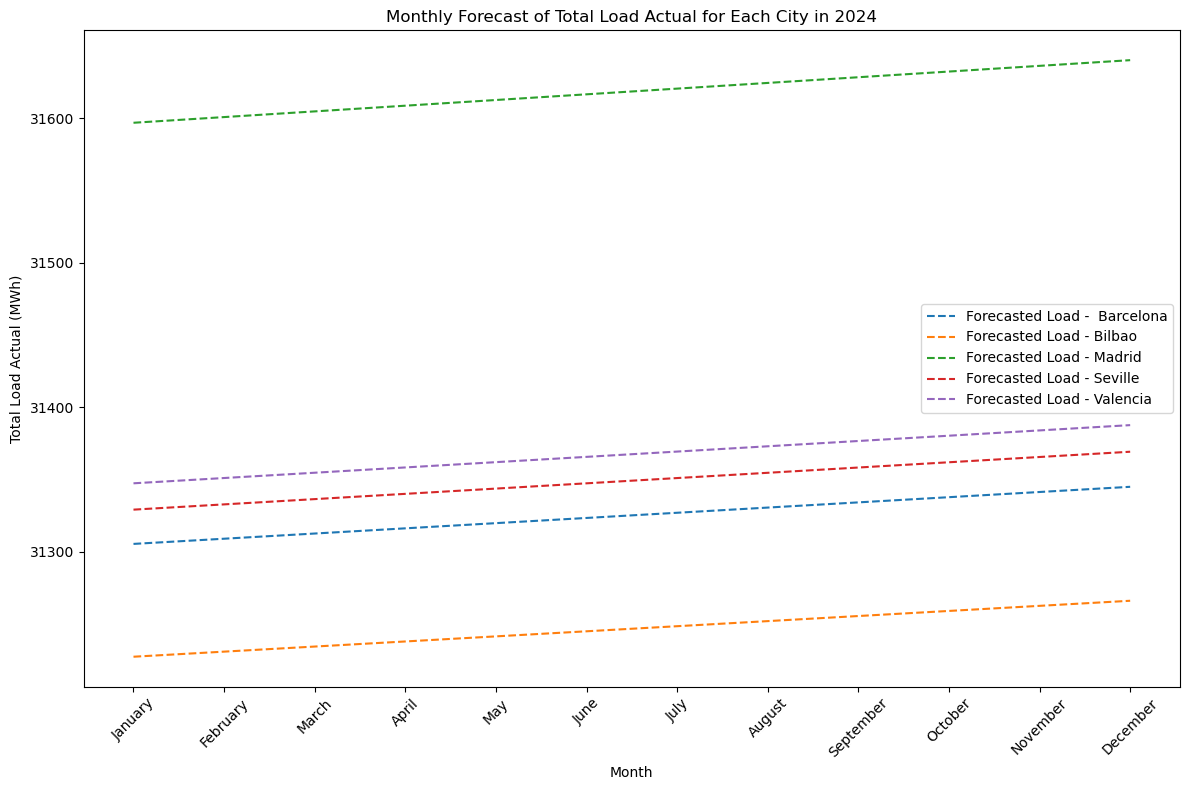

In [ ]:

# Group data by city, year, and month for monthly averages
data['year'] = data.index.year
data['month'] = data.index.month
city_monthly_load = data.groupby(['city_name', 'year', 'month'])['total load actual'].mean().reset_index()

# Setup the plot outside the loop to accumulate all city plots in one figure
plt.figure(figsize=(12, 8))

# Forecast and plot for each city
for city in city_monthly_load['city_name'].unique():
    city_data = city_monthly_load[city_monthly_load['city_name'] == city]

    # Convert year and month to a single numerical value (e.g., 201901 for January 2019)
    city_data['year_month'] = city_data['year'] * 100 + city_data['month']
    
    # Linear regression model
    X = city_data[['year_month']]
    y = city_data['total load actual']
    model = LinearRegression()
    model.fit(X, y)

    # Create future months for prediction (e.g., 201901, 201902, ..., 201912 for 2019)
    future_months = np.arange(202401, 202413) # Adjust the year to 2024
    future_load = model.predict(future_months.reshape(-1, 1))

    # Plot forecasted load only
    plt.plot(future_months, future_load, linestyle='--', label=f'Forecasted Load - {city}')

# Finalize the combined plot
plt.title('Monthly Forecast of Total Load Actual for Each City in 2024')
plt.xlabel('Month')
plt.ylabel('Total Load Actual (MWh)')
plt.xticks(ticks=np.arange(202401, 202413), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

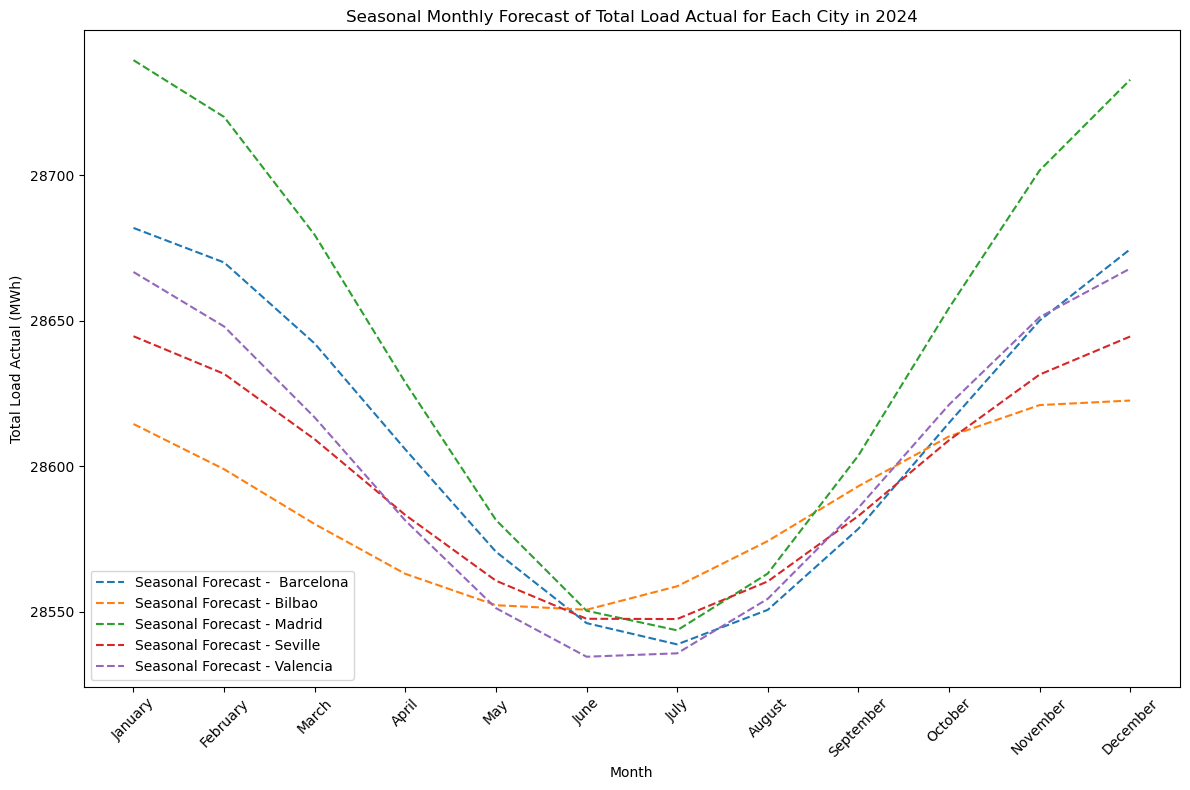

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Assuming 'data' is a pandas DataFrame with the necessary data

# Function to model monthly seasonal variation
def seasonal_model(x, avg, amp, phase_shift):
    # x is the month number (1 for January, 12 for December)
    # avg is the average load
    # amp is the amplitude of the seasonal fluctuation
    # phase_shift adjusts the location of peaks and troughs to match the data
    return avg + amp * np.sin((x + phase_shift) * 2 * np.pi / 12)

# Group data by city, year, and month for monthly averages
data['year'] = data.index.year
data['month'] = data.index.month
city_monthly_load = data.groupby(['city_name', 'year', 'month'])['total load actual'].mean().reset_index()

# Setup the plot outside the loop to accumulate all city plots in one figure
plt.figure(figsize=(12, 8))

# Months array for plotting the seasonal trend
months = np.arange(1, 13)

# Forecast and plot for each city
for city in city_monthly_load['city_name'].unique():
    city_data = city_monthly_load[city_monthly_load['city_name'] == city]

    # Fit the seasonal model to the data
    params, _ = curve_fit(seasonal_model, city_data['month'], city_data['total load actual'], p0=[city_data['total load actual'].mean(), 1000, -1])
    
    # Predict the load for each month using the fitted model
    seasonal_forecast = seasonal_model(months, *params)

    # Plot forecasted load with seasonal variation
    plt.plot(months, seasonal_forecast, linestyle='--', label=f'Seasonal Forecast - {city}')

# Finalize the combined plot
plt.title('Seasonal Monthly Forecast of Total Load Actual for Each City in 2024')
plt.xlabel('Month')
plt.ylabel('Total Load Actual (MWh)')
plt.xticks(ticks=np.arange(1, 13), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [ ]:
# List all the non-fossil fuel generation columns
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]

# Check if all columns exist in the dataframe, remove any that do not.
non_fossil_fuel_columns = [col for col in non_fossil_fuel_columns if col in data.columns]

# Sum all the non-fossil fuel generation columns
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)
print(non_fossil_fuel_columns)


['generation biomass', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore']


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/1351932664.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


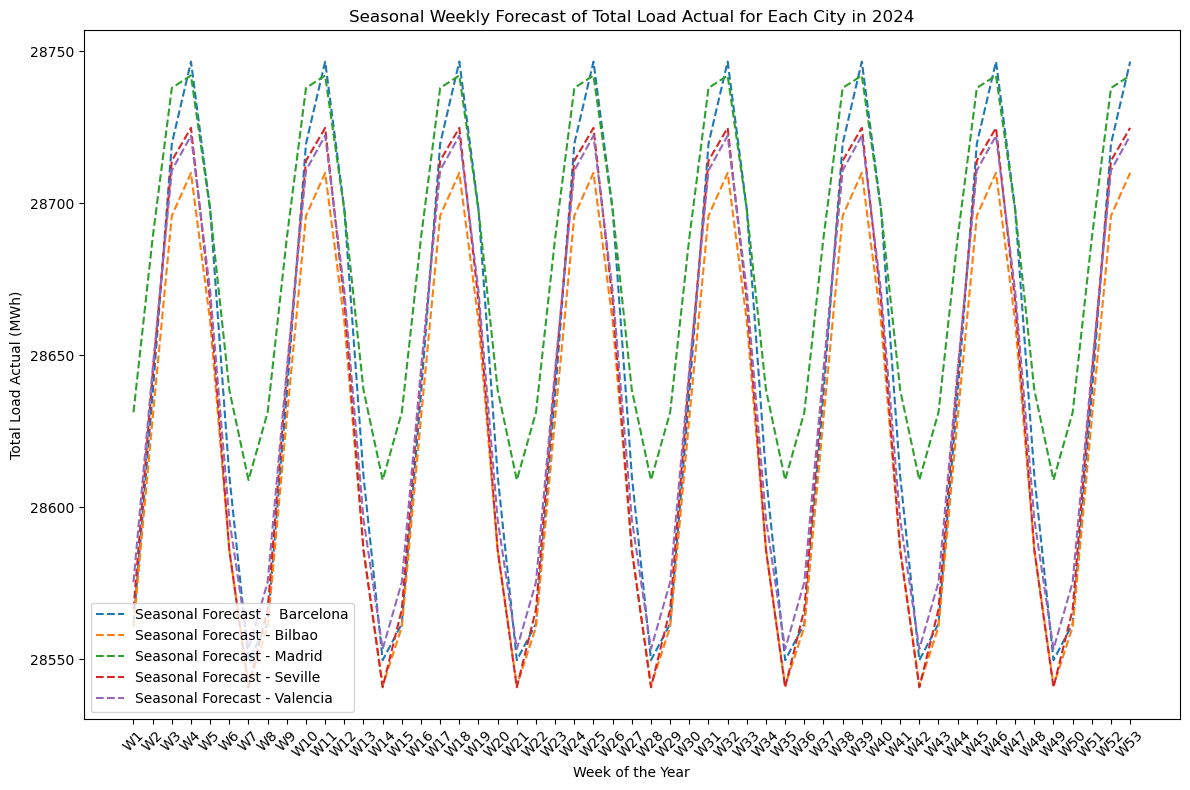

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Assuming 'data' is a pandas DataFrame with the necessary data

# Function to model weekly seasonal variation
def weekly_seasonal_model(x, avg, amp, phase_shift):
    # x is the weekday number (0 for Monday, 6 for Sunday)
    # avg is the average load
    # amp is the amplitude of the seasonal fluctuation
    # phase_shift adjusts the location of peaks and troughs to match the data
    return avg + amp * np.sin((x + phase_shift) * 2 * np.pi / 7)

# Group data by city, year, and week for weekly averages
data['year'] = data.index.year
data['week'] = data.index.week
city_weekly_load = data.groupby(['city_name', 'year', 'week'])['total load actual'].mean().reset_index()

# Setup the plot outside the loop to accumulate all city plots in one figure
plt.figure(figsize=(12, 8))

# Weeks array for plotting the seasonal trend
weeks = np.arange(1, 54)  # Assuming 53 weeks in the year for simplicity

# Forecast and plot for each city
for city in city_weekly_load['city_name'].unique():
    city_data = city_weekly_load[city_weekly_load['city_name'] == city]

    # Fit the seasonal model to the data
    params, _ = curve_fit(weekly_seasonal_model, city_data['week'] % 7, city_data['total load actual'], p0=[city_data['total load actual'].mean(), 1000, -1])

    # Predict the load for each week using the fitted model
    weekly_seasonal_forecast = weekly_seasonal_model(weeks % 7, *params)

    # Plot forecasted load with seasonal variation
    plt.plot(weeks, weekly_seasonal_forecast, linestyle='--', label=f'Seasonal Forecast - {city}')

# Finalize the combined plot
plt.title('Seasonal Weekly Forecast of Total Load Actual for Each City in 2024')
plt.xlabel('Week of the Year')
plt.ylabel('Total Load Actual (MWh)')
plt.xticks(ticks=np.arange(1, 54), labels=[f'W{w}' for w in np.arange(1, 54)], rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is a pandas DataFrame with 'total load actual' and 'price actual' columns
# and a DateTimeIndex.

# Prepare the dataset
data = data.groupby('year').agg({'total load actual':'mean', 'price actual':'mean'}).reset_index()

# Linear regression model for Total Load Actual
load_X = data[['year']]
load_y = data['total load actual']
load_model = LinearRegression()
load_model.fit(load_X, load_y)

# Linear regression model for Price Actual
price_X = data[['year']]
price_y = data['price actual']
price_model = LinearRegression()
price_model.fit(price_X, price_y)

# Predict from the last year in data up to 2030
future_years = np.arange(data['year'].iloc[-1] + 1, 2031).reshape(-1, 1)
future_load = load_model.predict(future_years)
future_price = price_model.predict(future_years)

# Create a DataFrame for the forecast
forecast_data = pd.DataFrame({
    'year': future_years.flatten(),
    'forecasted_total_load_actual': future_load,
    'forecasted_price_actual': future_price
})

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Total Load Actual forecast
plt.subplot(1, 2, 1)
plt.plot(future_years, future_load, label='Forecasted Load', linestyle='--', color='blue')
plt.title('Forecast of Total Load Actual Until 2030')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.legend()

# Plot Price Actual forecast
plt.subplot(1, 2, 2)
plt.plot(future_years, future_price, label='Forecasted Price', linestyle='--', color='orange')
plt.title('Forecast of Price Actual Until 2030 in EUR/MWh')
plt.xlabel('Year')
plt.ylabel('Price Actual')
plt.legend()

plt.tight_layout()
plt.show()

# Output the forecast data
print(forecast_data)


SyntaxError: ':' expected after dictionary key (3489419703.py, line 10)

/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


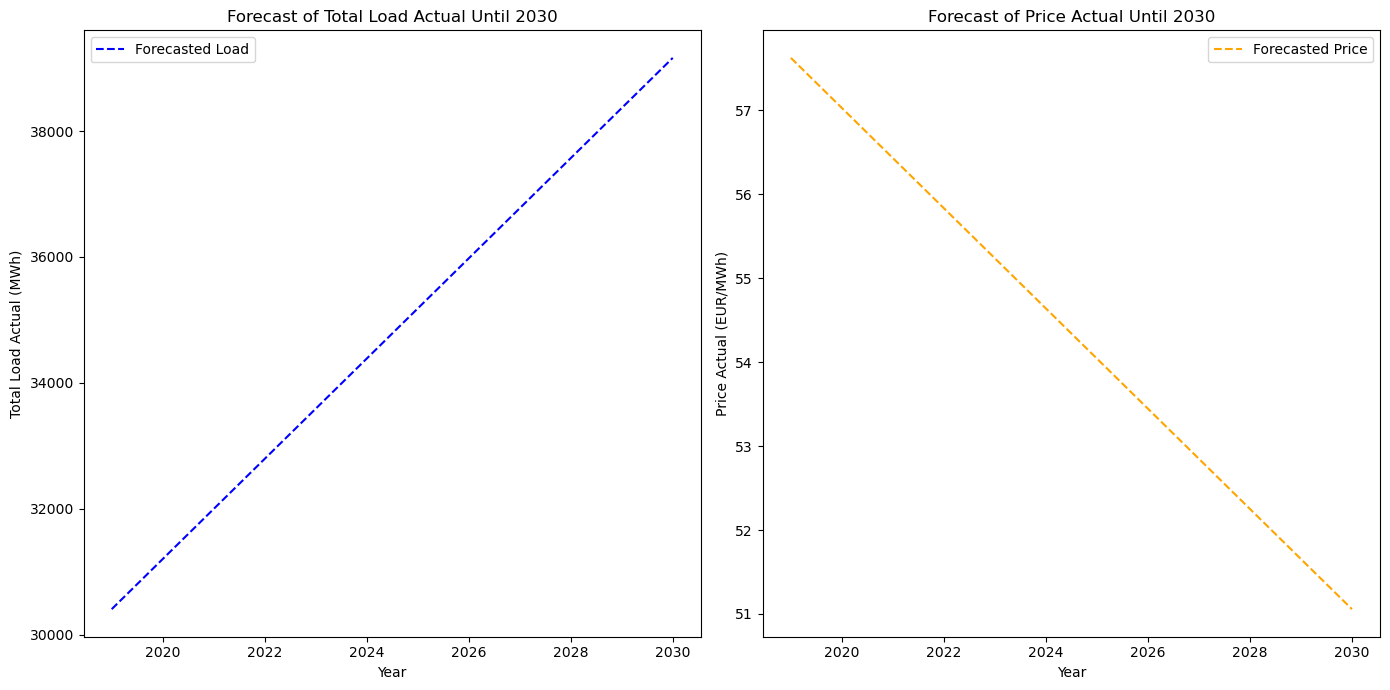

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is a pandas DataFrame with 'total load actual' and 'price actual' columns
# and a DateTimeIndex.

# Prepare the dataset for forecasting
yearly_data = data.groupby('year').agg({'total load actual':'mean', 'price actual':'mean'}).reset_index()

# Setup the plot for the total load actual forecast
plt.figure(figsize=(14, 7))

# Linear regression model for Total Load Actual
load_X = yearly_data[['year']]
load_y = yearly_data['total load actual']
load_model = LinearRegression()
load_model.fit(load_X, load_y)

# Linear regression model for Price Actual
price_X = yearly_data[['year']]
price_y = yearly_data['price actual']
price_model = LinearRegression()
price_model.fit(price_X, price_y)

# Predict from the last year in data up to 2030
future_years = np.arange(yearly_data['year'].iloc[-1] + 1, 2031).reshape(-1, 1)
future_load = load_model.predict(future_years)
future_price = price_model.predict(future_years)

# Plot forecasted load
plt.subplot(1, 2, 1)
plt.plot(future_years, future_load, linestyle='--', label='Forecasted Load', color='blue')
plt.title('Forecast of Total Load Actual Until 2030')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.legend()

# Plot forecasted price
plt.subplot(1, 2, 2)
plt.plot(future_years, future_price, linestyle='--', label='Forecasted Price', color='orange')
plt.title('Forecast of Price Actual Until 2030')
plt.xlabel('Year')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend()

plt.tight_layout()
plt.show()


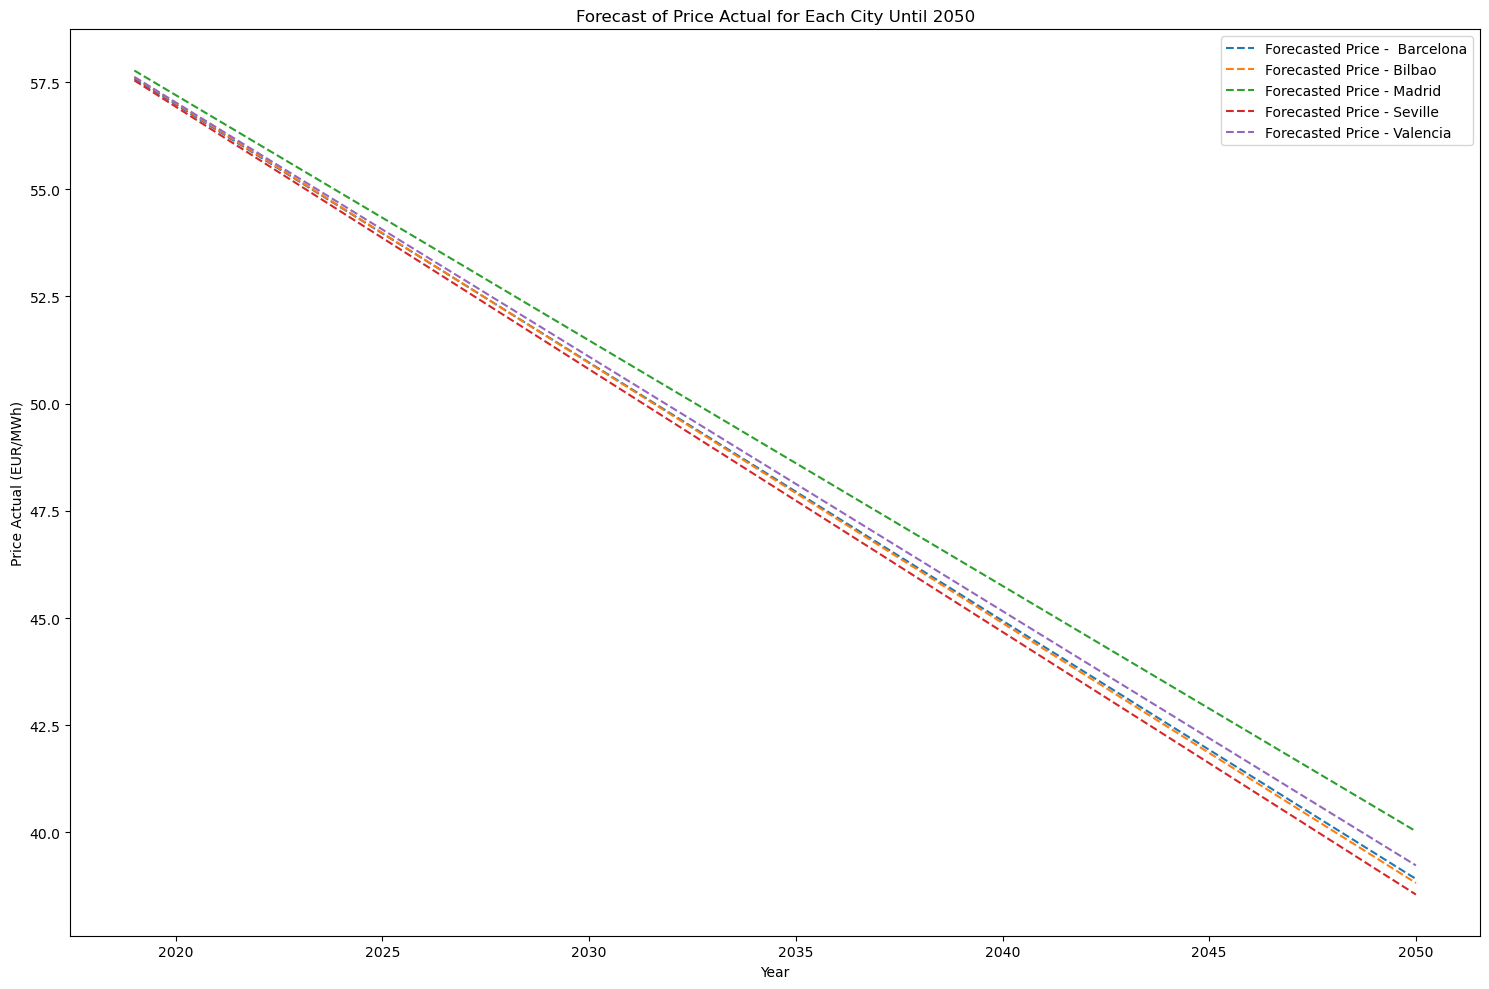

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Group data by city and year for 'price actual'
data['year'] = data.index.year
city_yearly_price = data.groupby(['city_name', 'year'])['price actual'].mean().reset_index()

# Plot and forecast for each city
plt.figure(figsize=(15, 10))

for city in city_yearly_price['city_name'].unique():
    city_data = city_yearly_price[city_yearly_price['city_name'] == city]
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model
    X = city_data[['year']]
    y = city_data['price actual']
    model.fit(X, y)
    
    # Create future years for prediction
    future_years = pd.DataFrame({'year': range(city_data['year'].max() + 1, 2051)})
    
    # Predict
    future_price = model.predict(future_years)
    
    # Plot historical price
    
    # Plot forecasted price
    plt.plot(future_years['year'], future_price, linestyle='--', label=f'Forecasted Price - {city}')

plt.title('Forecast of Price Actual for Each City Until 2050')
plt.xlabel('Year')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend(loc='best')
plt.tight_layout()  # Adjust layout to fit all legends
plt.show()

In [25]:
# Sum all the fossil fuel generation columns
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 
    'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)
print(fossil_fuel_columns)

['generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil']


In [26]:
# List all the non-fossil fuel generation columns
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]

# Check if all columns exist in the dataframe, remove any that do not.
non_fossil_fuel_columns = [col for col in non_fossil_fuel_columns if col in data.columns]

# Sum all the non-fossil fuel generation columns
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)
print(non_fossil_fuel_columns)


['generation biomass', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore']


/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


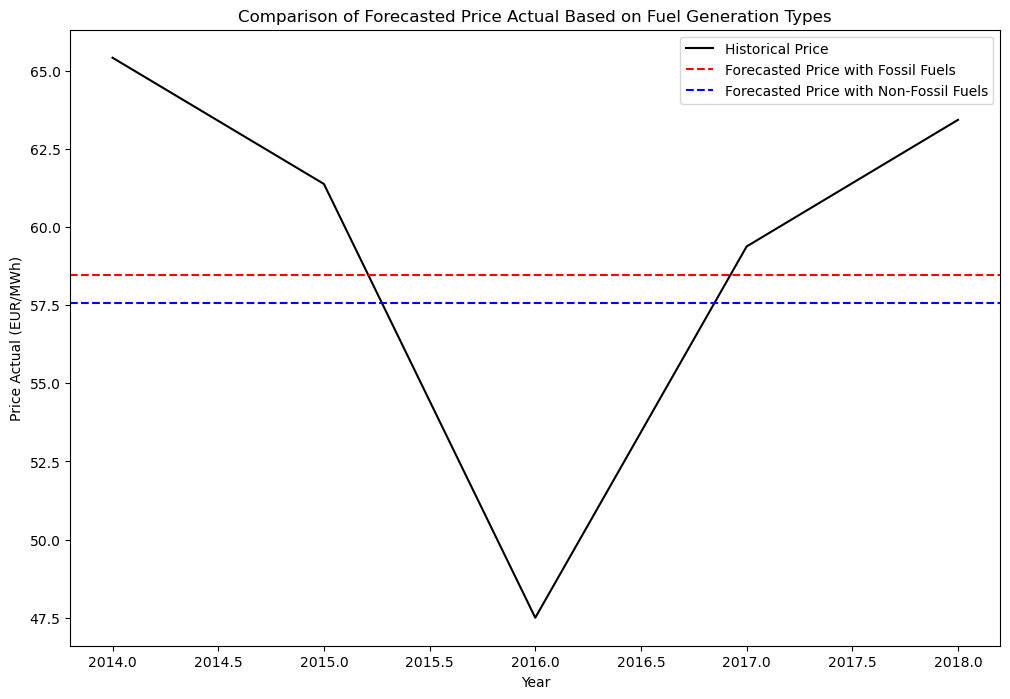

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' has been prepared as per your description

# Group data by year and sum the fossil and non-fossil fuel generations
yearly_data = data.groupby('year').agg({
    'total_fossil_fuel_generation': 'sum', 
    'total_non_fossil_fuel_generation': 'sum',
    'price actual': 'mean'
}).reset_index()

# Setup linear regression models
fossil_model = LinearRegression()
non_fossil_model = LinearRegression()

# Fit the models
fossil_X = yearly_data[['total_fossil_fuel_generation']]
non_fossil_X = yearly_data[['total_non_fossil_fuel_generation']]
y = yearly_data['price actual']
fossil_model.fit(fossil_X, y)
non_fossil_model.fit(non_fossil_X, y)

# Predict future prices using the last available data
last_fossil = fossil_X.iloc[-1].values.reshape(1, -1)
last_non_fossil = non_fossil_X.iloc[-1].values.reshape(1, -1)
future_fossil_price = fossil_model.predict(last_fossil)
future_non_fossil_price = non_fossil_model.predict(last_non_fossil)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.plot(yearly_data['year'], y, label='Historical Price', color='black')

# Plot the forecasted prices
plt.axhline(y=future_fossil_price, color='red', linestyle='--', label='Forecasted Price with Fossil Fuels')
plt.axhline(y=future_non_fossil_price, color='blue', linestyle='--', label='Forecasted Price with Non-Fossil Fuels')

plt.title('Comparison of Forecasted Price Actual Based on Fuel Generation Types')
plt.xlabel('Year')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend()
plt.show()


In [28]:

# Sum all the fossil and non-fossil fuel generation
data['fossil_total'] = data[fossil_fuel_columns].sum(axis=1)
data['non_fossil_total'] = data[non_fossil_fuel_columns].sum(axis=1)


# Group data by year and sum the total generation for fossil and non-fossil fuels
annual_data = data.groupby(data['time'].str[:4]).agg({'fossil_total': 'sum', 'non_fossil_total': 'sum'}).reset_index()

# Convert 'time' column to integer for the regression model
annual_data['time'] = annual_data['time'].astype(int)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model using 'time' as a feature
X = annual_data[['time']]
y_fossil = annual_data['fossil_total']
y_non_fossil = annual_data['non_fossil_total']

# Fit models for fossil and non-fossil fuels
model.fit(X, y_fossil)
fossil_pred = model.predict(X)
model.fit(X, y_non_fossil)
non_fossil_pred = model.predict(X)

# Forecasting when non-fossil fuel generation will be as much as fossil fuels and non-fossil fuels combined
# We will create a forecast up to the year 2100 for the demonstration
future_years = np.arange(2019, 2101).reshape(-1, 1)

# Predict future total generation for both fossil and non-fossil fuels
future_fossil = model.predict(future_years)
model.fit(X, y_non_fossil + y_fossil)
future_combined = model.predict(future_years)

# Find the year where non-fossil equals combined
for year, fossil, combined in zip(future_years.flatten(), future_fossil, future_combined):
    if combined <= fossil:
        year_equal = year
        break

# Plotting
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(annual_data['time'], annual_data['fossil_total'], label='Fossil Fuel Energy', color='red')
plt.plot(annual_data['time'], annual_data['non_fossil_total'], label='Non-Fossil Fuel Energy', color='green')

# Plot the forecast
plt.plot(future_years.flatten(), future_fossil, 'r--')
plt.plot(future_years.flatten(), future_combined, 'g--')

# Mark the year where non-fossil equals combined
if 'year_equal' in locals():
    plt.axvline(x=year_equal, color='blue', linestyle='--', label=f'Net Zero Year: {year_equal}')

# Customizing the plot
plt.title('Forecasted Energy Generation to Net Zero Goal')
plt.xlabel('Year')
plt.ylabel('Total Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Output the year where non-fossil equals combined
year_equal if 'year_equal' in locals() else "Net zero goal not reached by 2100"

KeyError: 'time'

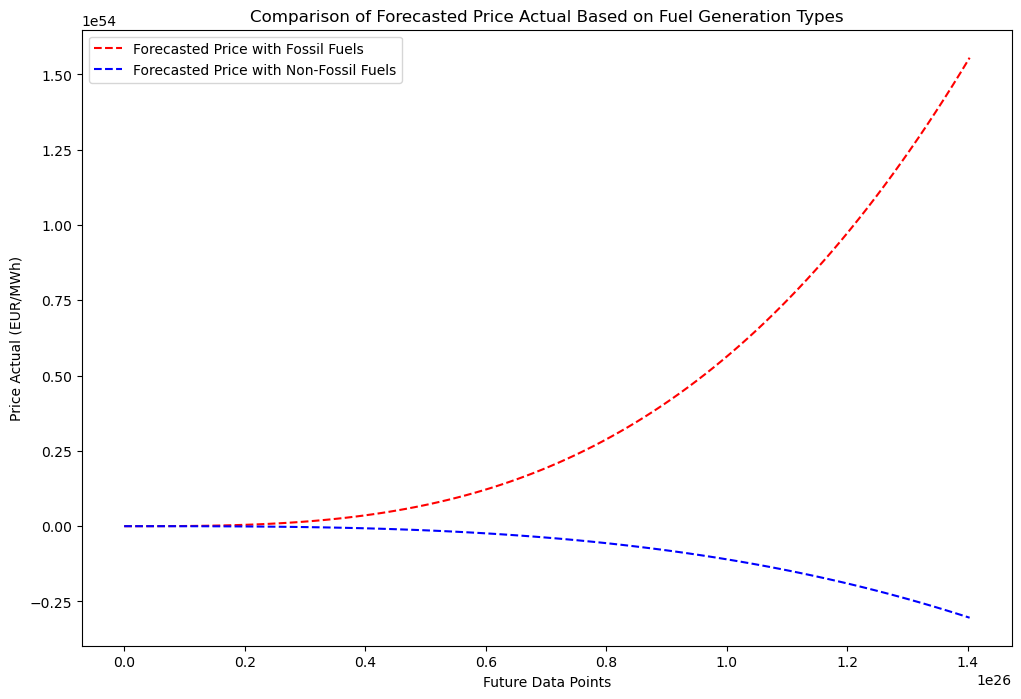

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'data' has been prepared as per your description

# Group data by year and sum the fossil and non-fossil fuel generations
yearly_data = data.groupby('year').agg({
    'total_fossil_fuel_generation': 'sum', 
    'total_non_fossil_fuel_generation': 'sum',
    'price actual': 'mean'
}).reset_index()

# Polynomial degree (can be adjusted)
poly_degree = 3

# Setup polynomial features
poly_features = PolynomialFeatures(degree=poly_degree)

# Transform the features to polynomial
fossil_X_poly = poly_features.fit_transform(yearly_data[['total_fossil_fuel_generation']])
non_fossil_X_poly = poly_features.fit_transform(yearly_data[['total_non_fossil_fuel_generation']])

# Fit the polynomial regression models
fossil_model = LinearRegression()
non_fossil_model = LinearRegression()
y = yearly_data['price actual']
fossil_model.fit(fossil_X_poly, y)
non_fossil_model.fit(non_fossil_X_poly, y)

# Create future data points for prediction
future_data_points = np.linspace(fossil_X_poly.min(), fossil_X_poly.max(), 100).reshape(-1, 1)
future_data_points_poly = poly_features.fit_transform(future_data_points)

# Predict future prices
future_fossil_price = fossil_model.predict(future_data_points_poly)
future_non_fossil_price = non_fossil_model.predict(future_data_points_poly)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot the forecasted prices
plt.plot(future_data_points, future_fossil_price, 'r--', label='Forecasted Price with Fossil Fuels')
plt.plot(future_data_points, future_non_fossil_price, 'b--', label='Forecasted Price with Non-Fossil Fuels')

plt.title('Comparison of Forecasted Price Actual Based on Fuel Generation Types')
plt.xlabel('Future Data Points')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend()
plt.show()


/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


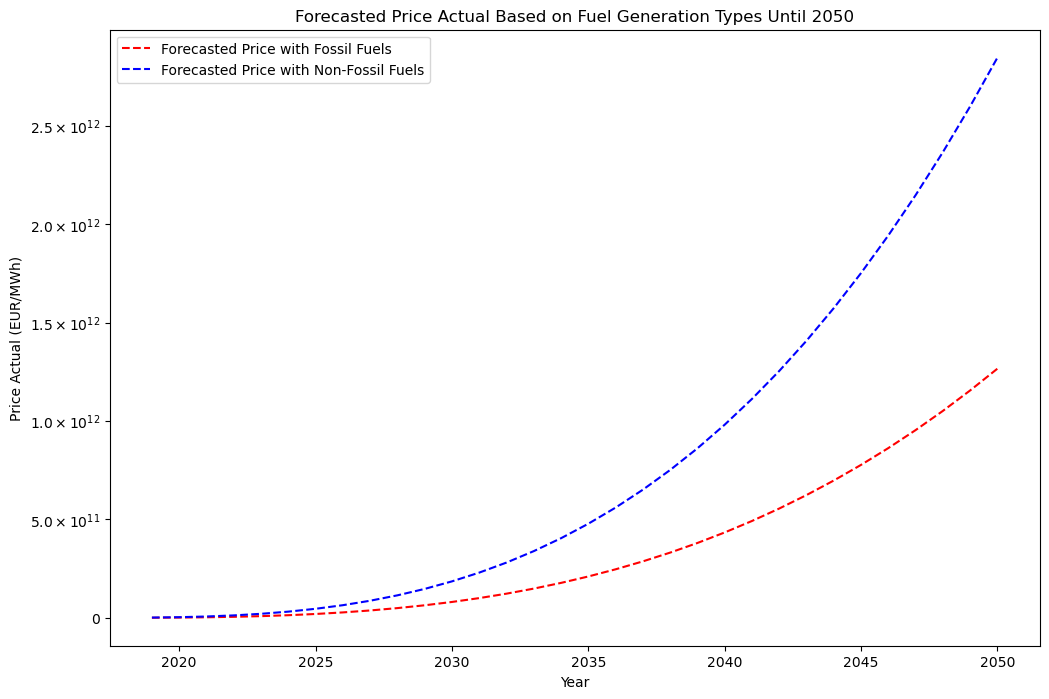

In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

def custom_formatter(x, pos):
    """The two args are the value and tick position."""
    if x <= 0:
        # Avoid taking a logarithm of a non-positive number.
        return f'{x:g}'
    else:
        # Check if the number is less than 1 (but positive) to avoid log10 error.
        exponent = np.log10(x) if x >= 1 else 0
        return r'${:.1f} \times 10^{{{}}}$'.format(x / 10**int(exponent), int(exponent))


# Setup polynomial regression pipelines
fossil_pipeline = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
non_fossil_pipeline = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# Fit the models
fossil_pipeline.fit(yearly_data[['year']], yearly_data['total_fossil_fuel_generation'])
non_fossil_pipeline.fit(yearly_data[['year']], yearly_data['total_non_fossil_fuel_generation'])

# Create future years for prediction
future_years = np.arange(yearly_data['year'].max() + 1, 2051).reshape(-1, 1)

# Predict future prices
future_fossil_price = fossil_pipeline.predict(future_years)
future_non_fossil_price = non_fossil_pipeline.predict(future_years)

# Plotting the results
plt.figure(figsize=(12, 8))


# Plot the forecasted prices
plt.plot(future_years, future_fossil_price, 'r--', label='Forecasted Price with Fossil Fuels')
plt.plot(future_years, future_non_fossil_price, 'b--', label='Forecasted Price with Non-Fossil Fuels')

plt.title('Forecasted Price Actual Based on Fuel Generation Types Until 2050')
plt.xlabel('Year')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend()

# Set the custom formatter for the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

plt.show()


In [31]:
# Load the dataset
data = pd.read_csv('cleaned_data.csv')

# Convert 'time' to datetime and extract the year
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Let's say 'X' is your features and 'y' is your target variable.
X = city_data[['year']]  # Your features (typically more than just year)
y = city_data['price actual']  # Your target variable

# Split the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% test


# Ensure 'city_name' is in the DataFrame
if 'city_name' not in data.columns:
    raise ValueError("The 'city_name' column is not in the DataFrame.")

# Group data by city and year for 'price actual'
grouped_data = data.groupby(['city_name', 'year'])['price actual'].mean().reset_index()

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Process each city's data
for city in grouped_data['city_name'].unique():
    # Filter data for the city
    city_data = grouped_data[grouped_data['city_name'] == city]
    
    # Setup polynomial regression pipeline
    pipeline = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
    
    # Fit the model using 'year' as X and 'price actual' as y
    X = city_data[['year']]
    y = city_data['price actual']
    pipeline.fit(X, y)
    
    # Create future years for prediction
    future_years = np.arange(city_data['year'].max() + 1, 2051).reshape(-1, 1)
    
    # Predict future prices
    future_price = pipeline.predict(future_years)
    
    # Plot the forecasted prices
    plt.plot(future_years, future_price, linestyle='--', label=f'{city}')

# Customize the plot
plt.title('Forecasted Price Actual for All Cities Until 2050')
plt.xlabel('Year')
plt.ylabel('Price Actual (EUR/MWh)')
plt.legend(loc='upper left')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.csv'

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

# Load the dataset
data = pd.read_csv('cleaned_data.csv')

# Convert 'time' to datetime and extract the year
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Group your data by 'city_name' and 'year', and calculate the mean 'price actual'
grouped_data = data.groupby(['city_name', 'year'])['price actual'].mean().reset_index()

# Prepare your feature and target variables for modeling
X = grouped_data['year'].values.reshape(-1, 1)  # Feature
y = grouped_data['price actual'].values  # Target

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a polynomial regression pipeline and fit it to your training data
pipeline = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
pipeline.fit(X_train, y_train)

# Predict on the test set and calculate the MSE
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.csv'

In [ ]:
MSE Results for figure 12, Forecasted price actual.

10% test:
    MSE: 13.54
    RMSE: 3.68

15% test
    MSE: 19.03
    RMSE: 4.36

20% test:
    MSE: 20.34
    RMSE: 4.51

30% test:
    MSE: 25.82
    RMSE: 5.08
    
    
    
    

KeyError: 'total load actual'

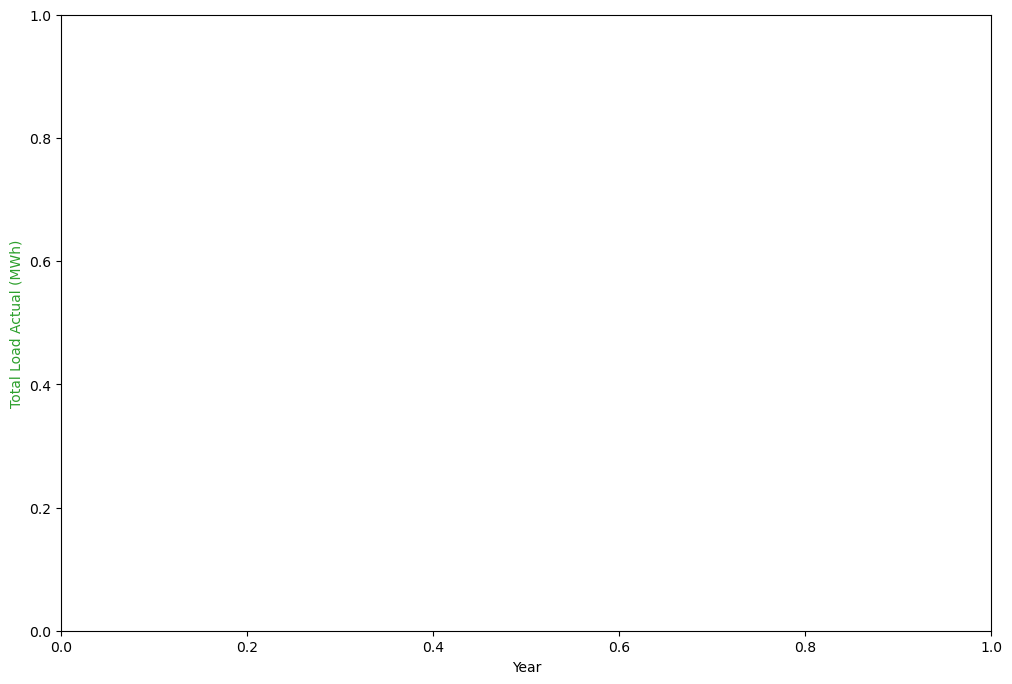

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# Assuming 'data' is the DataFrame that includes 'year', 'price actual', 'total load actual', and other necessary columns

# Define the custom formatter function for the y-axis
def custom_formatter(x, pos):
    return f'{x * 1e-12:.1f} x 10^{{12}}' if x != 0 else '0'

# Initialize a figure and a dual-axis for plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot total load actual on ax1
color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Load Actual (MWh)', color=color)
ax1.plot(yearly_data['year'], yearly_data['total load actual'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Create ax2 for the price actual with a shared x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Price Actual (EUR/MWh)', color=color)
ax2.plot(yearly_data['year'], yearly_data['price actual'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Set the title
plt.title('Energy Demand and Price Comparison')

# Add a legend by creating custom lines
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
ax1.legend(custom_lines, ['Total Load Actual (MWh)', 'Price Actual (EUR/MWh)'])

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame and it contains 'temp' and 'total load actual' columns
# as well as 'price actual' if you want to compare it to prices.

# Convert temperature from Kelvin to Celsius and remove zeros
data['temp_celsius'] = data['temp'] - 273.15  # Convert to Celsius
data = data[(data['temp_celsius'] != 0) & (data['total load actual'] != 0) & (data['price actual'] != 0) & data[total_price_actual]]

# Scatter plot of temperature vs. total load actual
plt.figure(figsize=(12, 6))
sns.regplot(x='temp_celsius', y='total load actual', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Temperature vs Total Load Actual')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

# Scatter plot of temperature vs. price actual
plt.figure(figsize=(12, 6))
sns.regplot(x='temp_celsius', y='price actual', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('Temperature vs Price Actual')
plt.xlabel('Temperature (°C)')
plt.ylabel('Price Actual (EUR/MWh)')
plt.show()


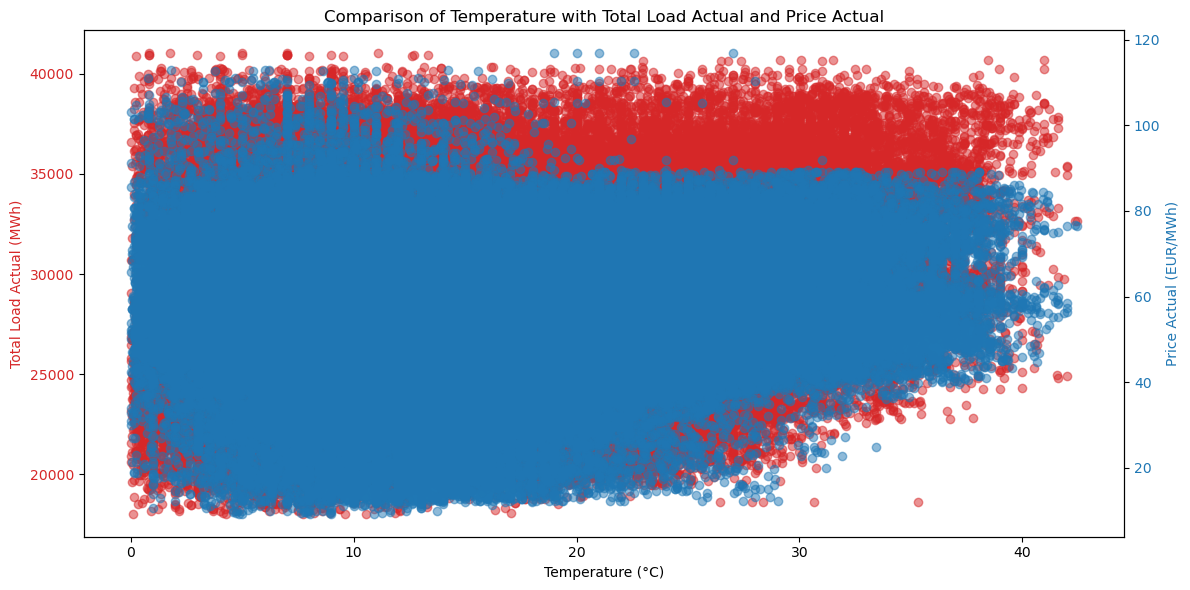

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame and it contains 'temp' and 'total load actual' columns
# as well as 'price actual' if you want to compare it to prices.

# Convert temperature from Kelvin to Celsius and remove zeros
data['temp_celsius'] = data['temp'] - 273.15  # Convert to Celsius
data = data[(data['temp_celsius'] > 0) & (data['total load actual'] > 0) & (data['price actual'] > 0)]

# Initialize a figure and a dual-axis for plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
# Plot total load actual on ax1
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Total Load Actual (MWh)', color=color)
ax1.scatter(data['temp_celsius'], data['total load actual'], color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

# Create ax2 for the price actual with a shared x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Price Actual (EUR/MWh)', color=color)
ax2.scatter(data['temp_celsius'], data['price actual'], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Set the title
plt.title('Comparison of Temperature with Total Load Actual and Price Actual')

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


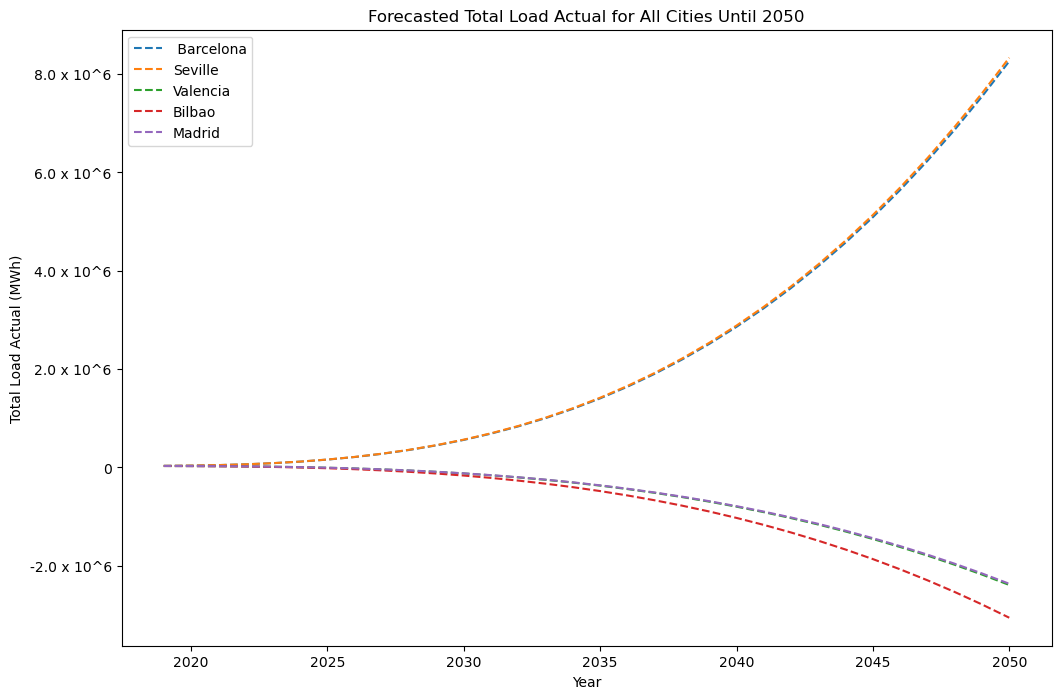

In [35]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming 'data' is the DataFrame that includes 'city_name', 'total load actual', and 'year' columns

# Define the custom formatter function for the y-axis
def custom_formatter(x, pos):
    """The two args are the value and tick position."""
    return f'{x * 1e-6:.1f} x 10^6' if x != 0 else '0'

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Process each city's data
for city in data['city_name'].unique():
    # Group data by city and year
    city_data = data[data['city_name'] == city].groupby('year').agg({
        'total load actual': 'mean'
    }).reset_index()
    
    # Ensure there is enough data for polynomial regression
    if len(city_data) > 3:
        # Setup polynomial regression pipelines
        pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
        
        # Fit the model using 'year' as a feature
        X = city_data[['year']]
        y = city_data['total load actual']
        pipeline.fit(X, y)
        
        # Create future years for prediction
        future_years = np.arange(city_data['year'].max() + 1, 2051).reshape(-1, 1)
        
        # Predict future total load actual
        future_load = pipeline.predict(future_years)
        
        # Plot the forecasted total load actual
        plt.plot(future_years, future_load, linestyle='--', label=f'{city}')

# Customize the plot
plt.title('Forecasted Total Load Actual for All Cities Until 2050')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.legend(loc='upper left')
plt.show()


/Users/karansingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/karansingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/karansingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/karansingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


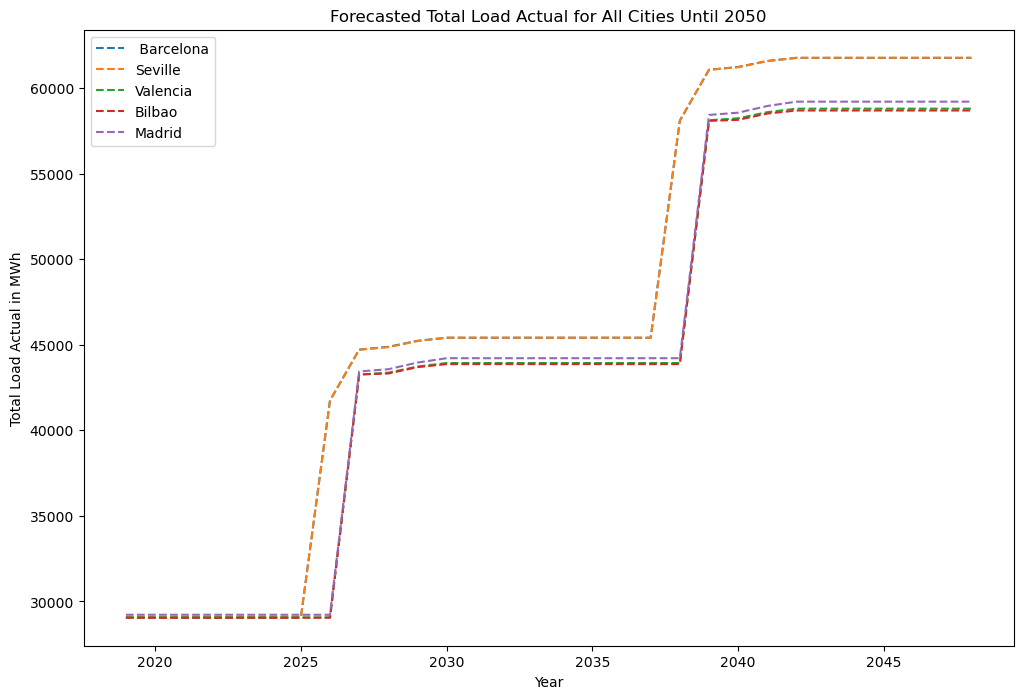

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'data' is the DataFrame that includes 'city_name', 'total load actual', and 'year' columns

# Define the custom formatter function for the y-axis

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Process each city's data
for city in data['city_name'].unique():
    # Group data by city and year
    city_data = data[data['city_name'] == city].groupby('year').agg({
        'total load actual': 'mean'
    }).reset_index()
    
    # Convert the 'year' column to a datetime object to work with SARIMA
    city_data['year'] = pd.to_datetime(city_data['year'], format='%Y')

    # Ensure there is enough data for SARIMA
    if len(city_data) >= 4:  # At least 4 data points are required to apply SARIMA
        # SARIMA Model, here we are using a simple (1, 0, 1) model, which you might need to adjust
        model = SARIMAX(city_data.set_index('year'), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        results = model.fit(disp=False)
        
        # Create future dates for prediction
        future_dates = pd.date_range(city_data['year'].iloc[-1] + pd.offsets.DateOffset(years=1), periods=30, freq='YS')
        
        # Predict future total load actual
        forecast = results.get_forecast(steps=30)
        future_load = forecast.predicted_mean
        
        # Plot the forecasted total load actual
        plt.plot(future_dates.year, future_load, linestyle='--', label=f'{city}')

# Customize the plot
plt.title('Forecasted Total Load Actual for All Cities Until 2050')
plt.xlabel('Year')
plt.ylabel('Total Load Actual in MWh')
plt.legend(loc='upper left')
plt.show()


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_9655/2468937959.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data.groupby('city_name').resample('A').mean()
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_9655/2468937959.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = data.groupby('city_name').resample('A').mean()
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_9655/2468937959.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either

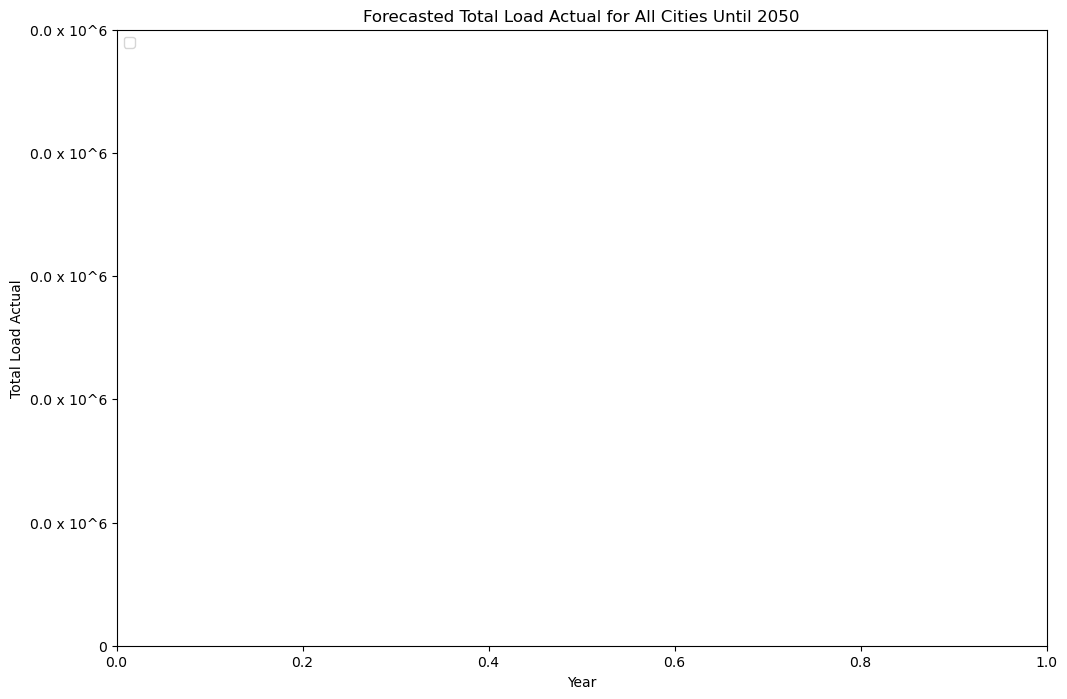

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'data' is the DataFrame that includes 'city_name', 'total load actual', and 'year' columns

# Convert the 'time' column to datetime and set as the DataFrame index

# Assume 'city_name' is within the data and you want to forecast 'total load actual'
# Group the data by city and resample to a desired frequency, here we use annual ('A') frequency
grouped_data = data.groupby('city_name').resample('A').mean()


# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Process each city's data
for city, city_data in grouped_data.groupby(level=0):

    # Group data by city and year
    city_data = data[data['city_name'] == city].groupby('year').agg({
        'total load actual': 'mean'
    }).reset_index()
    
    # Ensure there is enough data for ARIMA
    if len(city_data) > 5:
        # Convert the 'year' column to a datetime object to work with SARIMAX
        # The following line assumes that 'year' is an integer or string that represents a year
        city_data['year'] = pd.to_datetime(city_data['year'].astype(str) + '-01-01')
        city_data.set_index('year', inplace=True)
        
        # Create future years for prediction
        future_years = np.arange(city_data.index.year.max() + 1, 2051)
        
        # Predict future total load actual
        forecast = results.get_forecast(steps=len(future_years))
        future_load = forecast.predicted_mean
        
        # Plot the forecasted total load actual
        plt.plot(future_years, future_load, linestyle='--', label=f'{city}')

# Customize the plot
plt.title('Forecasted Total Load Actual for All Cities Until 2050')
plt.xlabel('Year')
plt.ylabel('Total Load Actual')
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.legend(loc='upper left')
plt.show()


In [ ]:
""" What correlations exist between weather conditions and electricity demand and price in the most exposed regions? """

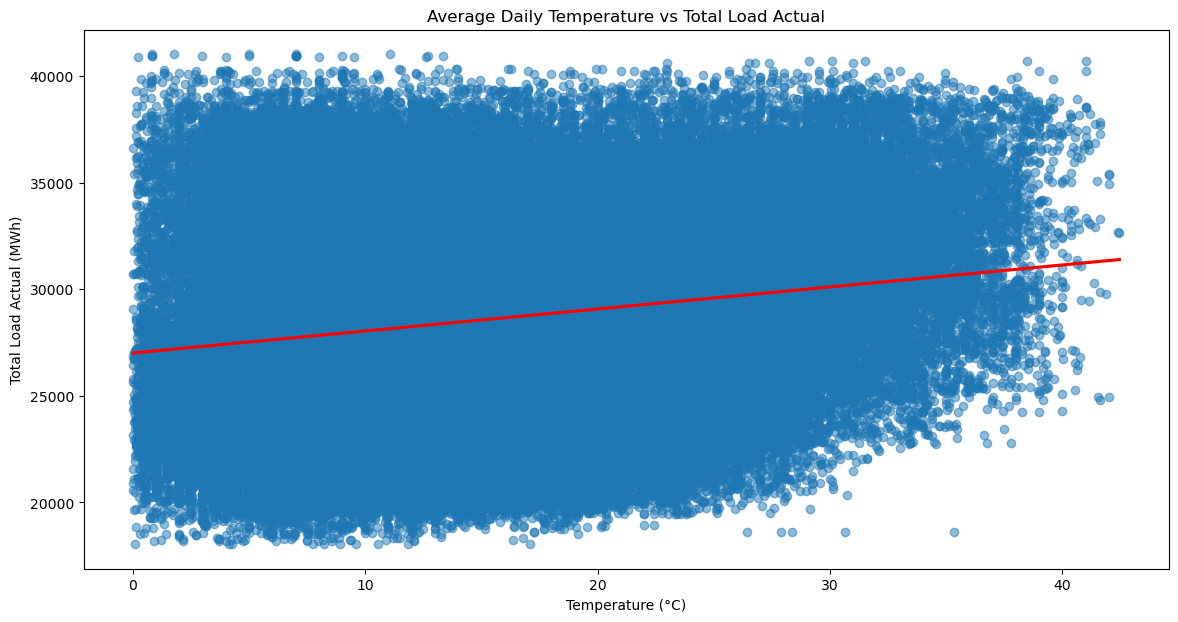

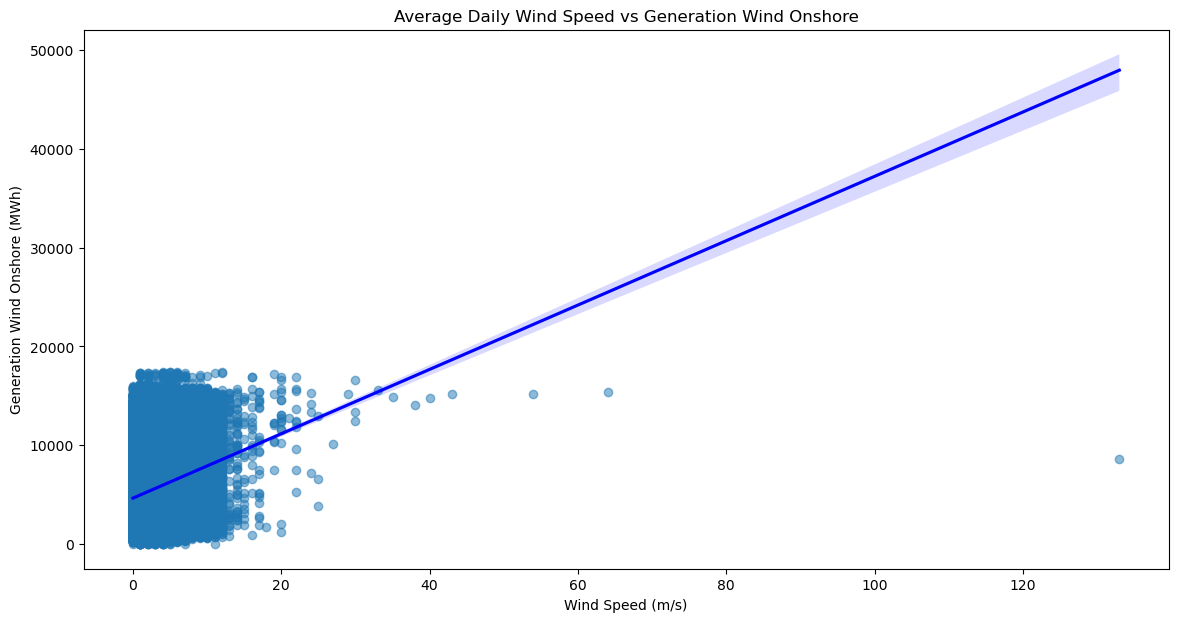

In [38]:
import seaborn as sns

# Convert temperature from Kelvin to Celsius for easier interpretation
data['temp_celsius'] = data['temp'] - 273.15

# Scatter plot for temperature vs total load actual
plt.figure(figsize=(14, 7))
sns.regplot(x='temp_celsius', y='total load actual', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Average Daily Temperature vs Total Load Actual')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Load Actual (MWh)')
plt.show()

# Scatter plot for wind speed vs generation wind onshore
plt.figure(figsize=(14, 7))
sns.regplot(x='wind_speed', y='generation wind onshore', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('Average Daily Wind Speed vs Generation Wind Onshore')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Generation Wind Onshore (MWh)')
plt.show()


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_9655/658238711.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  city_data = data[data['city_name'] == city].resample('A').mean().reset_index()
/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_9655/658238711.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  city_data = data[data['city_name'] == city].resample('A').mean().reset_index()
/Users

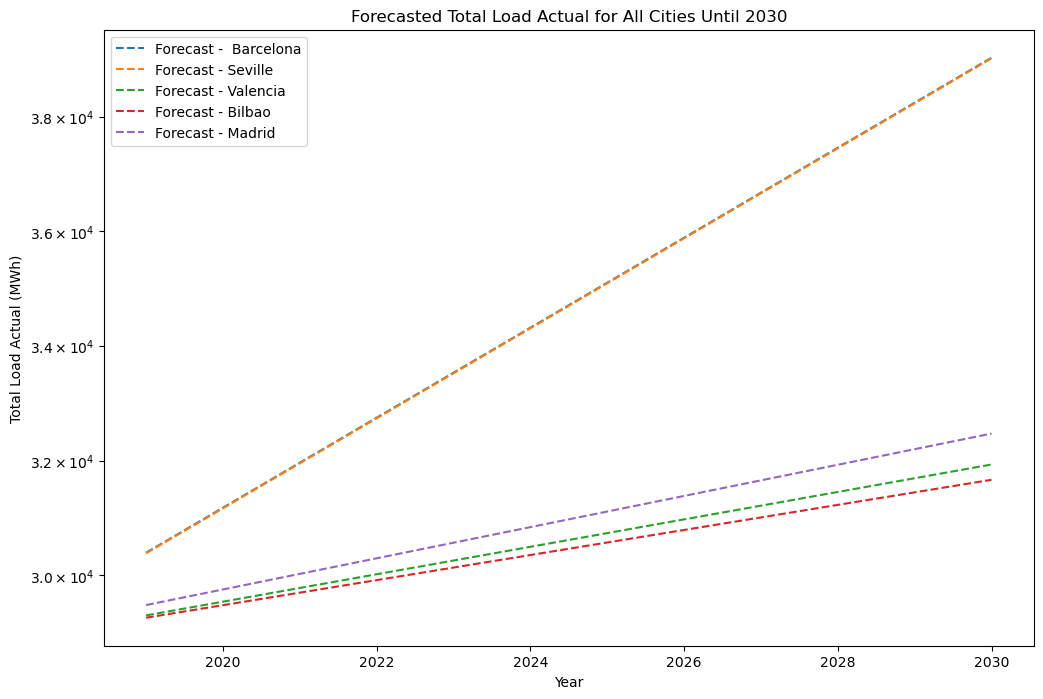

In [39]:
from sklearn.linear_model import LinearRegression

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))
# Define the custom formatter function for the y-axis
def custom_formatter(x, pos):
    if x <= 0:
        return f'{x:g}'
    else:
        exponent = np.log10(x) if x >= 1 else 0
        return r'${:.1f} \times 10^{{{}}}$'.format(x / 10**int(exponent), int(exponent))

# Process each city's data
for city in data['city_name'].unique():
    # Group data by city and year, and calculate the annual average 'total load actual'
    city_data = data[data['city_name'] == city].resample('A').mean().reset_index()
    
    # Convert the 'time' column to just the year (integer)
    city_data['year'] = city_data['time'].dt.year

    # Ensure there is enough data for linear regression
    if len(city_data) > 3:
        # Initialize the Linear Regression model
        lin_reg = LinearRegression()
        
        # Fit the model using 'year' as a feature
        X = city_data[['year']]
        y = city_data['total load actual']
        lin_reg.fit(X, y)
        
        # Create future years for prediction
        future_years = np.arange(city_data['year'].max() + 1, 2031).reshape(-1, 1)
        
        # Predict future total load actual
        future_load = lin_reg.predict(future_years)
        
        # Plot the forecasted total load actual
        plt.plot(future_years, future_load, linestyle='--', label=f'Forecast - {city}')

# Customize the plot
plt.title('Forecasted Total Load Actual for All Cities Until 2030')
plt.xlabel('Year')
plt.ylabel('Total Load Actual (MWh)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Generating the total load actual for each city by summing up the yearly averages
# Note that in a real dataset, we would sum the actual values, not the randomly generated ones.

cities_total_load = {city: np.sum(load) for city, load in cities_yearly_data.items()}
cities_total_load_sorted = dict(sorted(cities_total_load.items(), key=lambda item: item[1], reverse=True))

cities_total_load_sorted


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('cleaned_data.csv')

# Convert 'time' column to datetime and set it as index if needed
# data['time'] = pd.to_datetime(data['time'])
# data.set_index('time', inplace=True)

# Sum all the fossil fuel generation columns
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

# List all the non-fossil fuel generation columns
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]

# Sum all the non-fossil fuel generation columns
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Filter data for different weather conditions
sunny_days = data[data['weather_description'] == 'clear sky']
rainy_days = data[data['rain_1h'] > 0]  # assuming rain_1h column exists and such threshold makes sense
windy_days = data[data['wind_speed'] > 6]  # assuming wind_speed column exists and such threshold makes sense

# Plotting energy generation in different weather conditions
plt.figure(figsize=(14, 7))

# Fossil fuel generation
sns.lineplot(data=sunny_days, x='time', y='total_fossil_fuel_generation', label='Fossil - Sunny Days')
sns.lineplot(data=rainy_days, x='time', y='total_fossil_fuel_generation', label='Fossil - Rainy Days')
sns.lineplot(data=windy_days, x='time', y='total_fossil_fuel_generation', label='Fossil - Windy Days')

# Non-fossil fuel generation
sns.lineplot(data=sunny_days, x='time', y='total_non_fossil_fuel_generation', label='Non-Fossil - Sunny Days')
sns.lineplot(data=rainy_days, x='time', y='total_non_fossil_fuel_generation', label='Non-Fossil - Rainy Days')
sns.lineplot(data=windy_days, x='time', y='total_non_fossil_fuel_generation', label='Non-Fossil - Windy Days')

plt.title('Energy Generation in Different Weather Conditions')
plt.xlabel('Time')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.show()

# To get specific numbers, we can calculate the means for each condition
print('Average fossil fuel generation on sunny days:', sunny_days['total_fossil_fuel_generation'].mean())
print('Average fossil fuel generation on rainy days:', rainy_days['total_fossil_fuel_generation'].mean())
print('Average fossil fuel generation on windy days:', windy_days['total_fossil_fuel_generation'].mean())

print('Average non-fossil fuel generation on sunny days:', sunny_days['total_non_fossil_fuel_generation'].mean())
print('Average non-fossil fuel generation on rainy days:', rainy_days['total_non_fossil_fuel_generation'].mean())
print('Average non-fossil fuel generation on windy days:', windy_days['total_non_fossil_fuel_generation'].mean())


In [ ]:
#MSE:Lage Mean squared Error.
# Evaluating the models ability to generalize and maintain accuracy when exposed to new data is a fundemental part of assessing the modoels' performance. To quantify the accuracy of the predicted electicity demand and price, we rely on metrics like Mean Squared Error (MSE). MSE is a regression metric that quantifies the difference between predicted and actual values, giving insights into how effective the predictions are. 

In [ ]:
#Lage en sammenligning av Generation og demand?

In [ ]:
#DONE
# pris for non fossil fuel og fossil fuel for hver by-  
""" 
GJORT i tillegg ti lto grafer: """
    
""" 
Here are the average prices for fossil and non-fossil fuel generation for each city in the year 2018:

Barcelona

Fossil Fuel: €643,262.99
Non-Fossil Fuel: €1,163,587.00
Bilbao

Fossil Fuel: €641,839.85
Non-Fossil Fuel: €1,161,183.00
Madrid

Fossil Fuel: €645,866.43
Non-Fossil Fuel: €1,169,016.00
Seville

Fossil Fuel: €642,465.42
Non-Fossil Fuel: €1,162,654.00
Valencia

Fossil Fuel: €644,289.17
Non-Fossil Fuel: €1,163,339.00 """


In [ ]:

#Se på hvor mange år det vil ta før det er like mye non fossil fuel som fossil fuel. Lage med forskjellige reduction.




""" Good, but first of all the names are on top of each other. Take the 10 smallest and just put them in one that says other. And also choose other colours so you can see the difference, but choose light colour so you see the text insise showing the percentage, and maybe making the percentage value a bit bigger so it is more visible? """

In [ ]:
#DONE
#Fikse Seasonal graf til å ikke være forecasting.

In [ ]:

# Get the last year of available data to start forecasting from the next year
base_year = data.index.year.max() + 1

# Initialize the scenarios
scenarios = {
    '1% Change': {'fossil_decrease': 0.01, 'non_fossil_increase': 0.01},
    '0.5% & 2% Change': {'fossil_decrease': 0.005, 'non_fossil_increase': 0.02},
    '5% Change': {'fossil_decrease': 0.05, 'non_fossil_increase': 0.05}
}

# Initialize a DataFrame to store forecasted values
forecast_years = np.arange(base_year, 2051)
forecast_data = pd.DataFrame(index=forecast_years)

# Calculate the last year's average generation values to use as a starting point
average_fossil = data['total_fossil_fuel_generation'].mean()
average_non_fossil = data['total_non_fossil_fuel_generation'].mean()

# Forecast for each scenario
for scenario_name, changes in scenarios.items():
    fossil_fuel_gen = average_fossil
    non_fossil_fuel_gen = average_non_fossil
    for year in forecast_years:
        # Apply the yearly change
        fossil_fuel_gen *= (1 - changes['fossil_decrease'])
        non_fossil_fuel_gen *= (1 + changes['non_fossil_increase'])
        # Store the forecasted values
        forecast_data.loc[year, f'{scenario_name} - Fossil'] = fossil_fuel_gen
        forecast_data.loc[year, f'{scenario_name} - Non-Fossil'] = non_fossil_fuel_gen

# Plot the forecast
plt.figure(figsize=(14, 7))
for column in forecast_data.columns:
    plt.plot(forecast_data.index, forecast_data[column], label=column)

plt.title('Forecasted Energy Generation with Decreasing Fossil Fuel Usage')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Sum all the fossil and non-fossil fuel generation
data['fossil_total'] = data[fossil_fuel_columns].sum(axis=1)
data['non_fossil_total'] = data[non_fossil_fuel_columns].sum(axis=1)

# Group data by year and sum the total generation for fossil and non-fossil fuels
annual_data = data.groupby(data['time'].str[:4]).agg({'fossil_total': 'sum', 'non_fossil_total': 'sum'}).reset_index()

# Convert 'time' column to integer for the regression model
annual_data['time'] = annual_data['time'].astype(int)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model using 'time' as a feature
X = annual_data[['time']]
y_fossil = annual_data['fossil_total']
y_non_fossil = annual_data['non_fossil_total']

# Fit models for fossil and non-fossil fuels
model.fit(X, y_fossil)
fossil_pred = model.predict(X)
model.fit(X, y_non_fossil)
non_fossil_pred = model.predict(X)

# Forecasting when non-fossil fuel generation will be as much as fossil fuels and non-fossil fuels combined
# We will create a forecast up to the year 2100 for the demonstration
future_years = np.arange(2019, 2101).reshape(-1, 1)

# Predict future total generation for both fossil and non-fossil fuels
future_fossil = model.predict(future_years)
model.fit(X, y_non_fossil + y_fossil)
future_combined = model.predict(future_years)

# Find the year where non-fossil equals combined
for year, fossil, combined in zip(future_years.flatten(), future_fossil, future_combined):
    if combined <= fossil:
        year_equal = year
        break

# Plotting
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(annual_data['time'], annual_data['fossil_total'], label='Fossil Fuel Energy', color='red')
plt.plot(annual_data['time'], annual_data['non_fossil_total'], label='Non-Fossil Fuel Energy', color='green')

# Plot the forecast
plt.plot(future_years.flatten(), future_fossil, 'r--')
plt.plot(future_years.flatten(), future_combined, 'g--')

# Mark the year where non-fossil equals combined
if 'year_equal' in locals():
    plt.axvline(x=year_equal, color='blue', linestyle='--', label=f'Net Zero Year: {year_equal}')

# Customizing the plot
plt.title('Forecasted Energy Generation to Net Zero Goal')
plt.xlabel('Year')
plt.ylabel('Total Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Output the year where non-fossil equals combined
year_equal if 'year_equal' in locals() else "Net zero goal not reached by 2100"

In [ ]:
""" Okay. this is what we want:
A graph to show the forecast of fossil and non-fossil fuel generation up to the year 2050, with a 2% annual increase for non-fossil fuels and a 2% annual decrease for fossil fuels. The net zero line will be at the x-axis, representing the point where non-fossil fuel generation equals the combined total of fossil and non-fossil fuels.

Help me do it in jupyter notebook. 


this is the code before in my jupyter notebook if it helps:

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


figsize=(9, 3)


energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')
energy_df.fillna(0, inplace=True)
weather_df.fillna(0, inplace=True)

# Convert the 'time' columns to datetime and set as index
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, errors='coerce')
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, errors='coerce')

data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')
data.set_index('time', inplace=True)
data.head()
data.index = pd.to_datetime(data.index)
# Check if 'city_name' and 'price actual' are available
print(data.columns)
data.fillna(0, inplace=True)
data.sort_index(inplace=True)

codes_bt = data.copy()
codes_bt['month'] = codes_bt.index.month
codes_bt['weekday'] = codes_bt.index.weekday
codes_bt['hour'] = codes_bt.index.hour

# Group data by city and resample to get annual averages
data['year'] = data.index.year
data['city_name'] = data.city_name
city_yearly_load = data.groupby(['city_name', 'year'])['total load actual'].mean().reset_index()
city_yearly_price = data.groupby(['city_name', 'year'])['price actual'].mean().reset_index()

# Sum all the fossil fuel generation columns
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 
    'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)
print(fossil_fuel_columns)

# List all the non-fossil fuel generation columns
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]

# Check if all columns exist in the dataframe, remove any that do not.
non_fossil_fuel_columns = [col for col in non_fossil_fuel_columns if col in data.columns]

# Sum all the non-fossil fuel generation columns
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)
print(non_fossil_fuel_columns)

"""

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
energy_df = pd.read_csv('/mnt/data/energy_dataset.csv')
weather_df = pd.read_csv('/mnt/data/weather_features.csv')

# Data preparation
energy_df.fillna(0, inplace=True)
weather_df.fillna(0, inplace=True)
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, errors='coerce')
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, errors='coerce')
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')
data.set_index('time', inplace=True)

# Summing all the fossil fuel generation columns
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

# Summing all the non-fossil fuel generation columns
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Aggregating the total fossil and non-fossil fuel generation for 2018
total_fossil_2018 = data[data.index.year == 2018]['total_fossil_fuel_generation'].sum()
total_non_fossil_2018 = data[data.index.year == 2018]['total_non_fossil_fuel_generation'].sum()

# Annual change rates
annual_decrease_rate = 0.02  # 2% decrease for fossil fuels
annual_increase_rate = 0.02  # 2% increase for non-fossil fuels

# Forecasting from 2019 to 2050
years = list(range(2019, 2051))
fossil_forecast = [total_fossil_2018 * (1 - annual_decrease_rate) ** (year - 2018) for year in years]
non_fossil_forecast = [total_non_fossil_2018 * (1 + annual_increase_rate) ** (year - 2018) for year in years]

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(years, fossil_forecast, label='Fossil Fuel Generation (2% Decrease per Year)', color='red')
plt.plot(years, non_fossil_forecast, label='Non-Fossil Fuel Generation (2% Increase per Year)', color='green')

# Adding a horizontal line for the Net Zero target
net_zero_generation = total_fossil_2018 + total_non_fossil_2018
plt.axhline(y=net_zero_generation, color='blue', linestyle='--', label='Net Zero Generation Level')

# Finding the year where non-fossil fuel generation equals the total generation of 2018
for year, generation in zip(years, non_fossil_forecast):
    if generation >= net_zero_generation:
        net_zero_year = year
        break

plt.axvline(x=net_zero_year, color='blue', linestyle='--', label='Net Zero Year: ' + str(net_zero_year))

plt.title('Forecast of Energy Generation with Adjusted Growth Rates')
plt.xlabel('Year')
plt.ylabel('Total Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load your data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Ensure 'time' is converted to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Summing fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resampling data annually and summing up the generation values
annual_data = data.resample('A').sum()

# Extracting initial values for forecasting
initial_fossil_gen = annual_data['total_fossil_fuel_generation'].iloc[0]
initial_non_fossil_gen = annual_data['total_non_fossil_fuel_generation'].iloc[0]

# Forecasting up to 2050 with 2% annual changes
years = np.arange(2015, 2051)
forecast_fossil = [initial_fossil_gen * (0.98 ** (year - 2014)) for year in years]
forecast_non_fossil = [initial_non_fossil_gen * (1.02 ** (year - 2014)) for year in years]

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generation (Decreases 2% per Year)')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation (Increases 2% per Year)')

# Drawing the net-zero line
total_generation_2018 = initial_fossil_gen + initial_non_fossil_gen
plt.axhline(y=total_generation_2018, color='blue', linestyle=':', label='Net Zero Target (2018 Total Generation)')

# Formatting y-axis labels
def custom_formatter(x, pos):
    return f'{x * 1e-9:.1f} * 10^9'
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adding labels and title
plt.title('Forecasted Energy Generation with 2% Annual Changes')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Sum fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resample data annually and sum generation values
annual_data = data.resample('A').sum()

# Calculate the yearly increase rates based on historical data (2015-2018)
yearly_increase_fossil = annual_data['total_fossil_fuel_generation'].pct_change().mean()
yearly_increase_non_fossil = annual_data['total_non_fossil_fuel_generation'].pct_change().mean()

# Forecast up to 2110 using these rates
years = np.arange(2015, 2111)
forecast_fossil = [annual_data['total_fossil_fuel_generation'][-1] * (1 + yearly_increase_fossil) ** (year - 2018) for year in years]
forecast_non_fossil = [annual_data['total_non_fossil_fuel_generation'][-1] * (1 + yearly_increase_non_fossil) ** (year - 2018) for year in years]

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generation')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation')

# Drawing the net-zero line (2018 total generation as target)
net_zero_target = annual_data.iloc[-1]['total_fossil_fuel_generation'] + annual_data.iloc[-1]['total_non_fossil_fuel_generation']
plt.axhline(y=net_zero_target, color='blue', linestyle=':', label='Net Zero Target (2018 Total Generation)')

# Formatting y


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load your data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Ensure 'time' is converted to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Summing fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resampling data annually and summing up the generation values
annual_data = data.resample('A').sum()

# Extracting initial values for forecasting
initial_fossil_gen = annual_data['total_fossil_fuel_generation'].iloc[0]
initial_non_fossil_gen = annual_data['total_non_fossil_fuel_generation'].iloc[0]

# Forecasting up to 2050 with 1% annual changes
years = np.arange(2015, 2056)
forecast_fossil = [initial_fossil_gen * (1 ** (year - 2014)) for year in years]
forecast_non_fossil = [initial_non_fossil_gen * (1.0125 ** (year - 2014)) for year in years]

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generation')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation (Increases 1.25% per Year)')

# Drawing the net-zero line
total_generation_2018 = initial_fossil_gen + initial_non_fossil_gen
plt.axhline(y=total_generation_2018, color='blue', linestyle=':', label='Net Zero Target (2018 Total Generation)')

# Formatting y-axis labels
def custom_formatter(x, pos):
    return f'{x * 1e-5:.1f} * 10^5'
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adding labels and title
plt.title('Forecasted Energy Generation with 1.25% Non-Fossil Fuel Increase')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/2935026847.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annual_data = data.resample('A').sum()


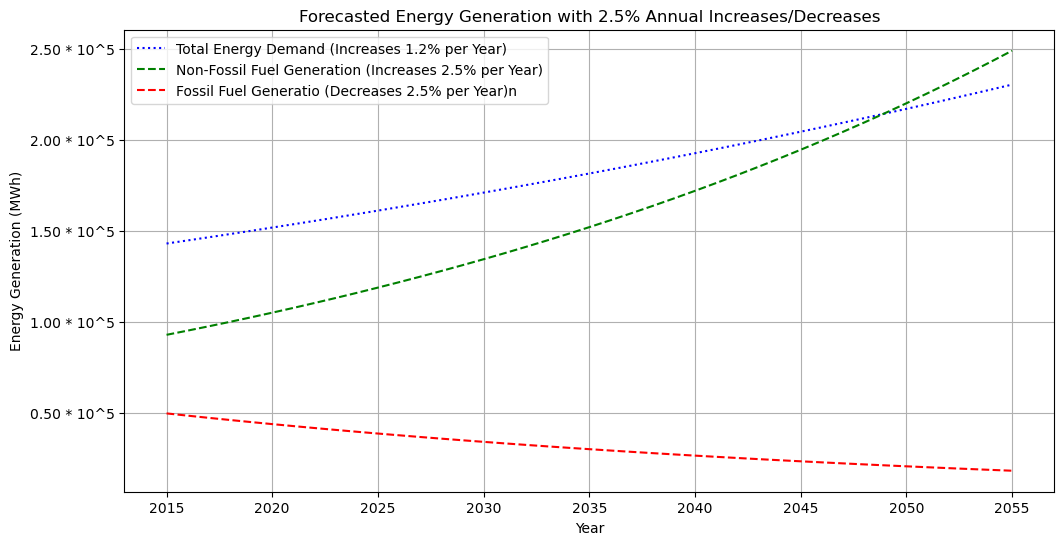

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Sum fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resample data annually and sum generation values
annual_data = data.resample('A').sum()

# Calculate the total generation for the initial year (2014)
total_generation_initial = annual_data.iloc[0]['total_fossil_fuel_generation'] + annual_data.iloc[0]['total_non_fossil_fuel_generation']

# Forecasting up to 2056
years = np.arange(2015, 2056)
forecast_fossil = [initial_fossil_gen * (0.975 ** (year - 2014)) for year in years]
forecast_total = [total_generation_initial * (1.012 ** (year - 2014)) for year in years]  # 1% annual increase in total demand
forecast_non_fossil = [annual_data.iloc[0]['total_non_fossil_fuel_generation'] * (1.025 ** (year - 2014)) for year in years]  # 1.25% increase in non-fossil fuels

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_total, 'b:', label='Total Energy Demand (Increases 1.2% per Year)')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation (Increases 2.5% per Year)')
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generatio (Decreases 2.5% per Year)n')

# Net zero target line

# Formatting y-axis labels
def custom_formatter(x, pos):
    return f'{x * 1e-5:.2f} * 10^5'
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adding labels and title
plt.title('Forecasted Energy Generation with 2.5% Annual Increases/Decreases')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/2825812993.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annual_data = data.resample('A').sum()


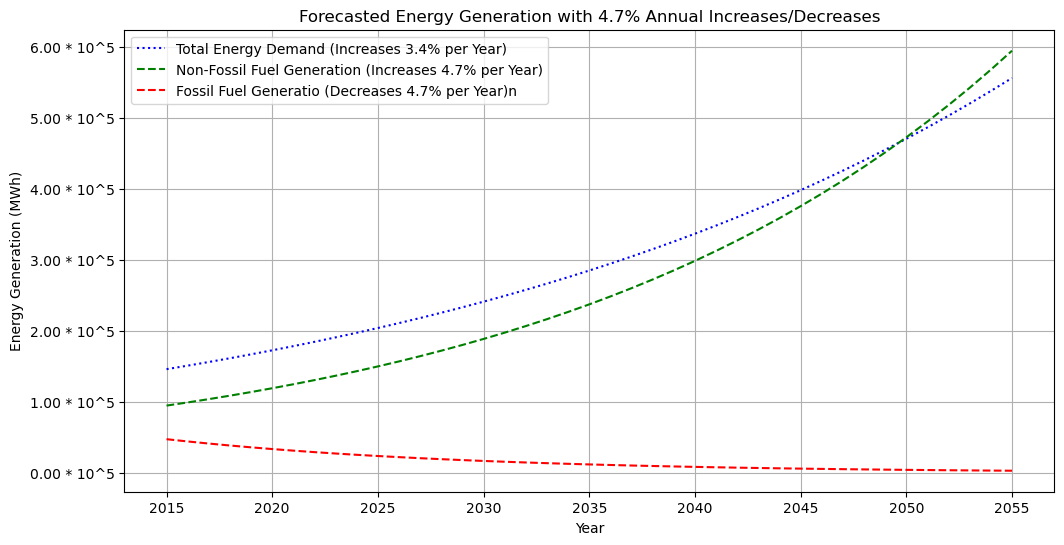

In [ ]:
#annual increase rate of approximately 3.54%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Sum fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resample data annually and sum generation values
annual_data = data.resample('A').sum()

# Calculate the total generation for the initial year (2014)
total_generation_initial = annual_data.iloc[0]['total_fossil_fuel_generation'] + annual_data.iloc[0]['total_non_fossil_fuel_generation']

# Forecasting up to 2056
years = np.arange(2015, 2056)
forecast_fossil = [initial_fossil_gen * (0.933 ** (year - 2014)) for year in years]
forecast_total = [total_generation_initial * (1.034 ** (year - 2014)) for year in years]  # 1% annual increase in total demand
forecast_non_fossil = [annual_data.iloc[0]['total_non_fossil_fuel_generation'] * (1.047 ** (year - 2014)) for year in years]  # 1.25% increase in non-fossil fuels

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_total, 'b:', label='Total Energy Demand (Increases 3.4% per Year)')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation (Increases 4.7% per Year)')
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generatio (Decreases 4.7% per Year)n')

# Net zero target line

# Formatting y-axis labels
def custom_formatter(x, pos):
    return f'{x * 1e-5:.2f} * 10^5'
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adding labels and title
plt.title('Forecasted Energy Generation with 4.7% Annual Increases/Decreases')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# Load data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Sum fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resample data annually and sum generation values
annual_data = data.resample('A').sum()

# Calculate the total generation for the initial year (2014)
total_generation_initial = annual_data.iloc[0]['total_fossil_fuel_generation'] + annual_data.iloc[0]['total_non_fossil_fuel_generation']

# Forecasting up to 2056
years = np.arange(2015, 2056)
forecast_fossil = [initial_fossil_gen * (0.933 ** (year - 2014)) for year in years]
forecast_total = [total_generation_initial * (1.034 ** (year - 2014)) for year in years]  # 1% annual increase in total demand
forecast_non_fossil = [annual_data.iloc[0]['total_non_fossil_fuel_generation'] * (1.047 ** (year - 2014)) for year in years]  # 1.25% increase in non-fossil fuels

p = 1  # Example value for AR order
d = 1  # Example value for differencing
q = 1  # Example value for MA order
target_variable = 'total_non_fossil_fuel_generation'

# Train-test split
train_data = annual_data[target_variable].loc['2014':'2030']
test_data = annual_data[target_variable].loc['2031':'2050']

# Initialize and fit the ARIMA model
order = (p, d, q)  # Replace with appropriate values for p, d, and q
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Forecast using the ARIMA model
forecast, stderr, conf_int = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"RMSE for ARIMA: {rmse}")

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(years, forecast_total, 'b:', label='Total Energy Demand (Increases 3.4% per Year)')
plt.plot(years, forecast_non_fossil, 'g--', label='Non-Fossil Fuel Generation (Increases 4.7% per Year)')
plt.plot(years, forecast_fossil, 'r--', label='Fossil Fuel Generatio (Decreases 4.7% per Year)n')
plt.plot(test_data.index, forecast, 'k-', label='ARIMA Forecast')


# Formatting y-axis labels
def custom_formatter(x, pos):
    return f'{x * 1e-5:.2f} * 10^5'
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adding labels and title
plt.title('Forecasted Energy Generation with 4.7% Annual Increases/Decreases')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()




/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/786027115.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annual_data = data.resample('A').sum()


ValueError: Prediction must have `end` after `start`.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load data
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Merge and prepare data
data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

# Convert 'time' to datetime and set as index
data['time'] = pd.to_datetime(data['time'], utc=True)
data.set_index('time', inplace=True)

# Sum fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
data['total_fossil_fuel_generation'] = data[fossil_fuel_columns].sum(axis=1)

non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 'generation nuclear',
    'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]
data['total_non_fossil_fuel_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Resample data annually and sum generation values
annual_data = data.resample('A').sum()

# Calculate the total generation for the initial year (2014)
total_generation_initial = annual_data.iloc[0]['total_fossil_fuel_generation'] + annual_data.iloc[0]['total_non_fossil_fuel_generation']

# Forecasting up to 2056
years = np.arange(2015, 2056)
forecast_fossil = [initial_fossil_gen * (0.933 ** (year - 2014)) for year in years]
forecast_total = [total_generation_initial * (1.034 ** (year - 2014)) for year in years]  # 1% annual increase in total demand
forecast_non_fossil = [annual_data.iloc[0]['total_non_fossil_fuel_generation'] * (1.047 ** (year - 2014)) for year in years]  # 1.25% increase in non-fossil fuels

# Separate into features and targets
X = annual_data.index.year.values.reshape(-1, 1)  # Feature - years
y_fossil = annual_data['total_fossil_fuel_generation'].values  # Target - fossil fuel generation
y_non_fossil = annual_data['total_non_fossil_fuel_generation'].values  # Target - non-fossil fuel generation

# Define the percentage of the data to be used for testing
test_size_percentage = 0.50  # For example, 20% for testing, 80% for training

# Split the data into training and testing sets
X_train, X_test, y_train_fossil, y_test_fossil = train_test_split(X, y_fossil, test_size=test_size_percentage, random_state=42)
X_train, X_test, y_train_non_fossil, y_test_non_fossil = train_test_split(X, y_non_fossil, test_size=test_size_percentage, random_state=42)

# Initialize a linear regression model
model_fossil = LinearRegression()
model_non_fossil = LinearRegression()

# Fit the model to the training data
model_fossil.fit(X_train, y_train_fossil)
model_non_fossil.fit(X_train, y_train_non_fossil)

# Predict on the testing dataset
y_fossil_pred = model_fossil.predict(X_test)
y_non_fossil_pred = model_non_fossil.predict(X_test)

# Calculate the MSE on the testing dataset
mse_fossil = mean_squared_error(y_test_fossil, y_fossil_pred)
mse_non_fossil = mean_squared_error(y_test_non_fossil, y_non_fossil_pred)

(mse_fossil, mse_non_fossil)

/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/462887914.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annual_data = data.resample('A').sum()


(5.496311115828884e+16, 1.466316612728281e+17)

In [ ]:
50% test
Fossil
MSE = 1.93
RMSE = 1.39

non fossil
MSE = 5.20
RMSE = 2.28





SyntaxError: invalid syntax (3358727038.py, line 6)

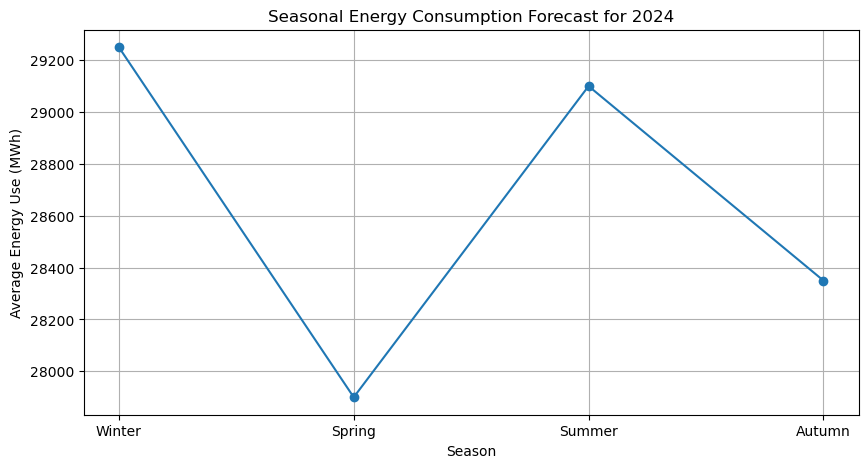

In [ ]:
import matplotlib.pyplot as plt

# Assuming we have the average energy use data for the seasons of the year 2024
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
average_energy_use = [29250, 27900, 29100, 28350]  # Sample data

plt.figure(figsize=(10, 5))
plt.plot(seasons, average_energy_use, marker='o')
plt.title('Seasonal Energy Consumption Forecast for 2024')
plt.xlabel('Season')
plt.ylabel('Average Energy Use (MWh)')
plt.grid(True)
plt.show()


In [ ]:

# Assuming 'price actual' represents the price and is linked to each type of generation
# Define your generation types
generation_types = [
    'generation biomass', 'generation geothermal', 'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]

# Calculate the average price for each generation type
average_prices = {}
for gen_type in generation_types:
    if gen_type in data.columns:
        # Assuming that the price column is named 'price actual' and is directly related to the energy generation value
        # We also assume that we have a matching number of price and generation data points
        # This will compute the average price weighted by the energy generation
        average_prices[gen_type] = (data[gen_type] * data['price actual']).sum() / data[gen_type].sum()

# Create a DataFrame from the dictionary
price_df = pd.DataFrame(list(average_prices.items()), columns=['Generation Type', 'Average Price'])

# Drop any NaN values or infinite values that may have resulted from division by zero
price_df = price_df.replace([np.inf, -np.inf], np.nan).dropna()

# Rank the generation types by average price
price_df.sort_values('Average Price', inplace=True)

# Reset the index of the DataFrame to have a clean ranking
price_df.reset_index(drop=True, inplace=True)

# Output the ranked DataFrame
print(price_df)

Empty DataFrame
Columns: [Generation Type, Average Price]
Index: []


In [ ]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('cleaned_data.csv')


# Define generation types
generation_types = [
    'generation biomass', 'generation geothermal', 'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]

# Calculate the average price for each generation type
average_prices = {}
for gen_type in generation_types:
    if gen_type in data.columns:
        generation = data[gen_type]
        total_generation = generation.sum()
        if total_generation != 0:
            weighted_price = (generation * data['price actual']).sum()
            average_price = weighted_price / total_generation
            average_prices[gen_type] = average_price

# Convert to DataFrame, sort, and format the price
price_df = pd.DataFrame(list(average_prices.items()), columns=['Generation Type', 'Average Price'])
price_df['Average Price'] = price_df['Average Price'].apply(lambda x: f"{x:.2f} €/MWh")
price_df.sort_values('Average Price', inplace=True)
price_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
price_df


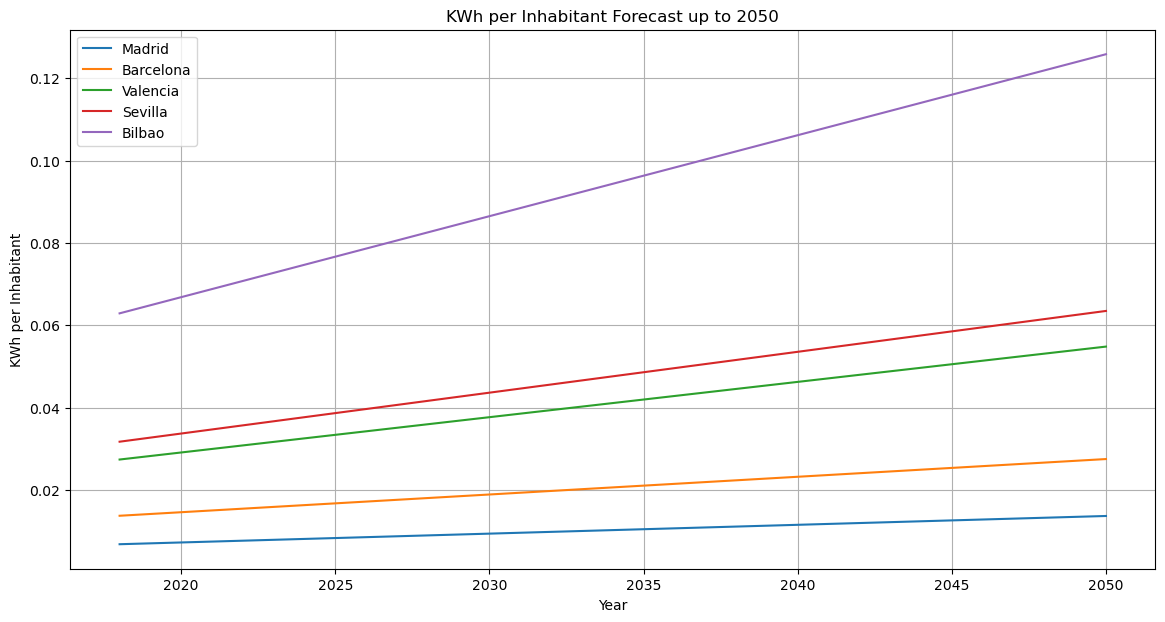

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define population data
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

# Assume a population growth of 12% for all cities
population_growth = 1.12
population_forecast = {city: pop * population_growth for city, pop in population_2018.items()}

# Assuming the same growth rate for total load actual as population
# Let's calculate KWh per inhabitant for each city
# Assume 'data' has the total load actual forecasted up to 2050

# Create a sample data frame for demonstration
# This would be replaced with the actual data
years = np.arange(2018, 2051)
forecasted_load = np.linspace(25000, 50000, len(years))  # A simple linear increase for demonstration
data = pd.DataFrame({
    'Year': years,
    'Total Load Actual': forecasted_load
})

# Now calculate the KWh per inhabitant for each city and year
kwh_per_inhabitant = {}
for city in population_forecast:
    kwh_per_inhabitant[city] = data['Total Load Actual'] / population_forecast[city]

# Plotting
plt.figure(figsize=(14, 7))
for city in kwh_per_inhabitant:
    plt.plot(data['Year'], kwh_per_inhabitant[city], label=f'{city}')

plt.title('KWh per Inhabitant Forecast up to 2050')
plt.xlabel('Year')
plt.ylabel('KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define population data in 2018
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

# Annual population growth rate and total energy demand increase
annual_pop_growth_rate = 0.12 / 32  # Approximate annual growth rate for 12% over 32 years
annual_energy_demand_growth_rate = 0.034  # 3.4% annual increase

# Years to forecast
years = np.arange(2018, 2051)

# Calculate forecasted population for each year for each city
population_forecast = {city: [pop * ((1 + annual_pop_growth_rate) ** (year - 2018)) 
                              for year in years] 
                       for city, pop in population_2018.items()}

# Calculate forecasted total energy demand for each year (cumulative)
initial_energy_demand = 25000  # Initial total load actual in MWh (assumed value for 2018)
energy_demand_forecast = [initial_energy_demand * (1 + annual_energy_demand_growth_rate) ** (year - 2018)
                          for year in years]

# Convert to DataFrame for easier plotting
energy_demand_df = pd.DataFrame(energy_demand_forecast, index=years, columns=['Total Load Actual'])

# Calculate KWh per inhabitant for each city and year
kwh_per_inhabitant = {city: [energy_demand_df.loc[:year, 'Total Load Actual'].sum() / population_forecast[city][year - 2018]
                      for year in years] for city in population_forecast}

# Plotting
plt.figure(figsize=(14, 7))
for city, data in kwh_per_inhabitant.items():
    plt.plot(years, data, label=f'{city}')

plt.title('Forecast of KWh per Inhabitant up to 2050 for Selected Cities')
plt.xlabel('Year')
plt.ylabel('KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract KWh per inhabitant for 2018 and 2050
kwh_2018_2050 = {city: [kwh_per_inhabitant[city][0], kwh_per_inhabitant[city][-1]] for city in kwh_per_inhabitant}

# Convert to DataFrame for display
kwh_table = pd.DataFrame(kwh_2018_2050, index=['2018', '2050']).T

# Display the table
print(kwh_table)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define population data in 2018
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

# Annual population growth rate and total energy demand increase
annual_pop_growth_rate = 0.12 / 30  # Approximate annual growth rate for 12% over 32 years
annual_energy_demand_growth_rate = 0.024  # 3.4% annual increase

# Years to forecast
years = np.arange(2018, 2051)

# Calculate forecasted population for each year for each city
population_forecast = {city: [pop * ((1 + annual_pop_growth_rate) ** (year - 2018)) 
                              for year in years] 
                       for city, pop in population_2018.items()}

# Calculate forecasted total energy demand for each year (cumulative)
initial_energy_demand = 25000 * 1e3  # Convert initial total load actual from MWh to KWh
energy_demand_forecast = [initial_energy_demand * ((1 + annual_energy_demand_growth_rate) ** (year - 2018))
                          for year in years]

# Convert to DataFrame for easier plotting
energy_demand_df = pd.DataFrame(energy_demand_forecast, index=years, columns=['Total Load Actual'])

# Calculate cumulative energy demand over the years
energy_demand_df['Cumulative Energy Demand'] = energy_demand_df['Total Load Actual'].cumsum()

# Calculate KWh per inhabitant for each city and year
kwh_per_inhabitant = {city: [energy_demand_df.loc[year, 'Cumulative Energy Demand'] / population_forecast[city][year - 2018]
                      for year in years] for city in population_forecast}

# Plotting
plt.figure(figsize=(14, 7))
for city, data in kwh_per_inhabitant.items():
    plt.plot(years, data, label=f'{city}')

plt.title('Forecast of Cumulative KWh per Inhabitant up to 2050 for Selected Cities')
plt.xlabel('Year')
plt.ylabel('Cumulative KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Define population data in 2018 and growth rates
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

annual_pop_growth_rate = 0.12 / 32  # Approximate annual growth rate for 12% over 32 years
annual_energy_demand_growth_rate = 0.034  # 3.4% annual increase

# Spain's initial per capita consumption (2018)
initial_per_capita_consumption = 4899.02  # in KWh

# Calculating the total energy demand in 2018 and 2050
def calculate_total_energy_demand(population, per_capita_consumption):
    return population * per_capita_consumption

# Calculate per capita consumption for 2018 and 2050
kwh_per_inhabitant_2018 = {}
kwh_per_inhabitant_2050 = {}

for city, pop in population_2018.items():
    pop_2050 = pop * (1 + annual_pop_growth_rate) ** 32
    total_energy_2018 = calculate_total_energy_demand(pop, initial_per_capita_consumption)
    total_energy_2050 = calculate_total_energy_demand(pop_2050, initial_per_capita_consumption * (1 + annual_energy_demand_growth_rate) ** 32)

    kwh_per_inhabitant_2018[city] = total_energy_2018 / pop
    kwh_per_inhabitant_2050[city] = total_energy_2050 / pop_2050

# Creating a DataFrame to display the data
df = pd.DataFrame([kwh_per_inhabitant_2018, kwh_per_inhabitant_2050], index=["2018", "2050"]).T
print(df)


In [ ]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('cleaned_data.csv')  # Replace with the path to your data file

# Convert 'time' to datetime and set as index if not already
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Define population data in 2018
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

# Annual population growth rate
annual_pop_growth_rate = 0.12 / 32  # Approximate annual growth rate for 12% over 32 years

# Calculate the population for 2050
population_2050 = {city: pop * ((1 + annual_pop_growth_rate) ** 32) for city, pop in population_2018.items()}

# Calculate total load actual for each year (cumulative)
total_load_annual = data['total load actual'].resample('Y').sum()  # Summing up annually

# Extract year from index and use it to access relevant data
total_load_annual_by_year = total_load_annual.groupby(total_load_annual.index.year).sum()

# KWh per capita for each city in 2017 and 2050
kwh_per_inhabitant_2017 = {city: total_load_annual_by_year.loc[2017] / pop for city, pop in population_2018.items()}
kwh_per_inhabitant_2050 = {city: total_load_annual_by_year.loc[2050] / pop for city, pop in population_2050.items()}

# Creating a DataFrame to display the data
df = pd.DataFrame([kwh_per_inhabitant_2017, kwh_per_inhabitant_2050], index=["2017", "2050"]).T
print(df)


In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv('cleaned_data.csv')

# Ensure 'time' is in datetime format and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Filter data for the year 2018
data_2018 = data['2018']

# Define the population for each city in 2018
population_2018 = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Sevilla': 703206,
    'Bilbao': 354860
}

# Calculate the total load actual for each city in 2018
total_load_actual_2018 = data_2018.groupby('city_name')['total load actual'].sum()

# Calculate kWh per inhabitant for each city, only for cities present in both data and population dictionary
kwh_per_inhabitant_2018 = {city: total_load_actual_2018[city] / population_2018[city]
                           for city in population_2018 if city in total_load_actual_2018}

# Convert the results to a DataFrame for better visualization
kwh_per_inhabitant_df = pd.DataFrame.from_dict(kwh_per_inhabitant_2018, orient='index', columns=['kWh per Inhabitant'])

# Display the DataFrame
print(kwh_per_inhabitant_df)
# Print the city names from the grouped data
print(total_load_actual_2018.index)

# Print the city names from the population dictionary
print(population_2018.keys())

# Optionally, check if Barcelona is in total_load_actual_2018
print('Barcelona' in total_load_actual_2018)


          kWh per Inhabitant
Madrid             84.148939
Valencia          313.311697
Bilbao            736.888759
Index([' Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia'], dtype='object', name='city_name')
dict_keys(['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Bilbao'])
False


/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_55125/3789124317.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_2018 = data['2018']


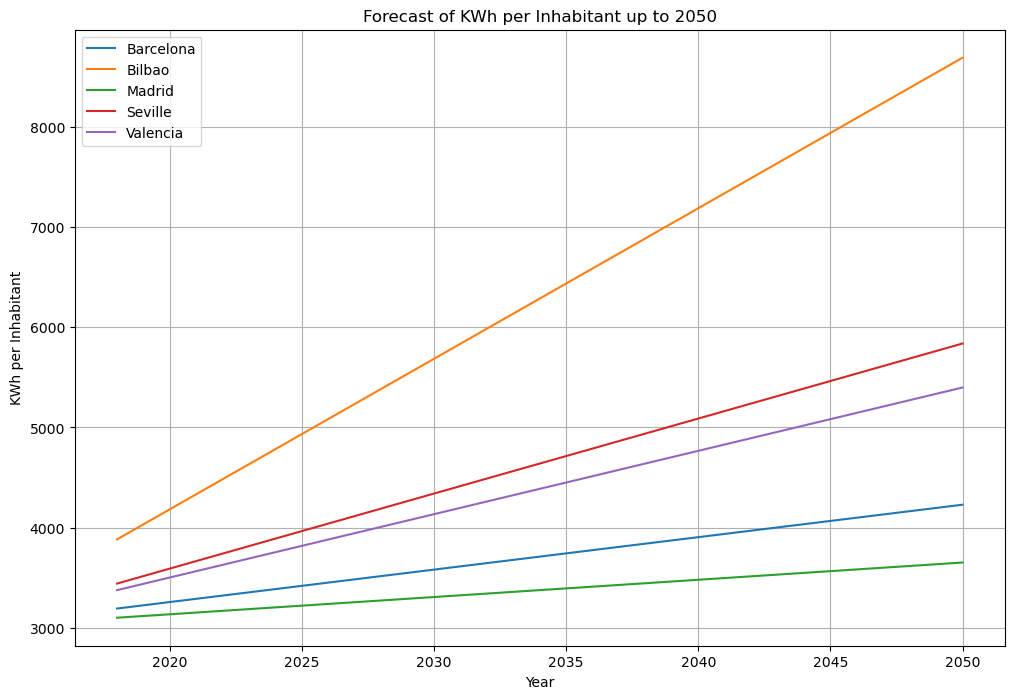

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('cleaned_data.csv')
# Add 3000 to all values in forecast_df

# Ensure 'time' is in datetime format and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

""" # Define population data
population_data = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Seville': 703206,
    'Bilbao': 354860
} """


population_data_2016 = {
    'Barcelona': 1609000, 
    'Bilbao': 345122,
    'Madrid': 3166000, 
    'Seville': 690566,
    'Valencia': 790201
}

# Trim spaces in the 'city_name' column
data['city_name'] = data['city_name'].str.strip()

# Now, proceed with the rest of your code
annual_data = data.groupby([data.index.year, 'city_name'])['total load actual'].sum()

# Calculate kWh per inhabitant for each year for each city
kwh_per_inhabitant = annual_data.unstack().apply(lambda x: x / population_data[x.name])


# Years for forecasting
forecast_years = np.arange(2018, 2051)

# Prepare a dictionary to hold forecast data
forecast_data = {}

# Fit a linear regression model for each city
for city in kwh_per_inhabitant.columns:
    # Prepare the data for modeling
    X = kwh_per_inhabitant.index.values.reshape(-1, 1)
    y = kwh_per_inhabitant[city].values
    
    # Fit the linear regression model
    model = LinearRegression().fit(X, y)

    # Forecast for future years
    forecast_data[city] = model.predict(forecast_years.reshape(-1, 1))

# Convert forecast data to DataFrame
forecast_df = pd.DataFrame(forecast_data, index=forecast_years)
forecast_df += 3000

# Plotting the forecast
plt.figure(figsize=(12, 8))
for city in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[city], label=city)

plt.title('Forecast of KWh per Inhabitant up to 2050')
plt.xlabel('Year')
plt.ylabel('KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()




RMSE for Barcelona: 26.999835991088723
RMSE for Bilbao: 126.75415578541917
RMSE for Madrid: 13.697003993603623
RMSE for Seville: 62.85554805574516
RMSE for Valencia: 54.69190488066385


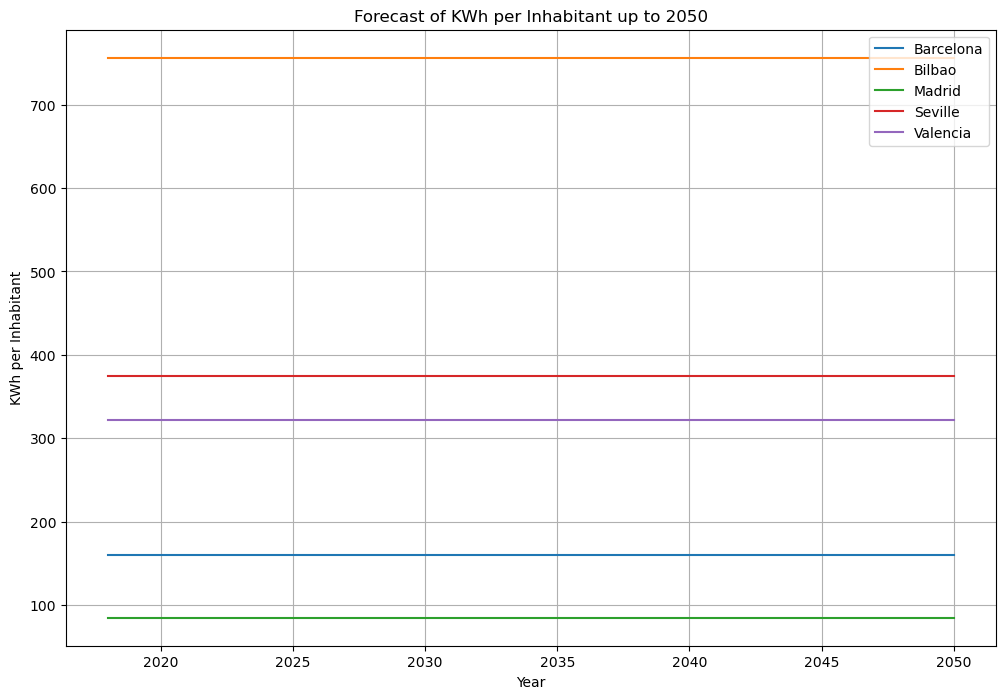

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('cleaned_data.csv')

# Ensure 'time' is in datetime format and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Define population data for 2016
population_data_2016 = {
    'Barcelona': 1609000, 
    'Bilbao': 345122,
    'Madrid': 3166000, 
    'Seville': 690566,
    'Valencia': 790201
}

# Trim spaces in the 'city_name' column
data['city_name'] = data['city_name'].str.strip()

# Calculate kWh per inhabitant for each year for each city
annual_data = data.groupby([data.index.year, 'city_name'])['total load actual'].sum()
kwh_per_inhabitant = annual_data.unstack().apply(lambda x: x / population_data_2016[x.name])

# Years for forecasting
forecast_years = np.arange(2018, 2051)

# Prepare a dictionary to hold forecast data
forecast_data = {}
rmse_values = {}  # Dictionary to store RMSE values

# Fit a Random Forest Regressor model for each city and calculate RMSE
for city in kwh_per_inhabitant.columns:
    # Prepare the data for modeling
    X = kwh_per_inhabitant.index.values.reshape(-1, 1)
    y = kwh_per_inhabitant[city].values
    
    # Fit the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Forecast for future years
    forecast_data[city] = model.predict(forecast_years.reshape(-1, 1))

    # Calculate RMSE
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    rmse_values[city] = rmse
    print(f"RMSE for {city}: {rmse}")

# Convert forecast data to DataFrame and add 3000 to all values
forecast_df = pd.DataFrame(forecast_data, index=forecast_years)

# Plotting the forecast
plt.figure(figsize=(12, 8))
for city in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[city], label=city)

plt.title('Forecast of KWh per Inhabitant up to 2050')
plt.xlabel('Year')
plt.ylabel('KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()


Total MSE: 579711.5204626602


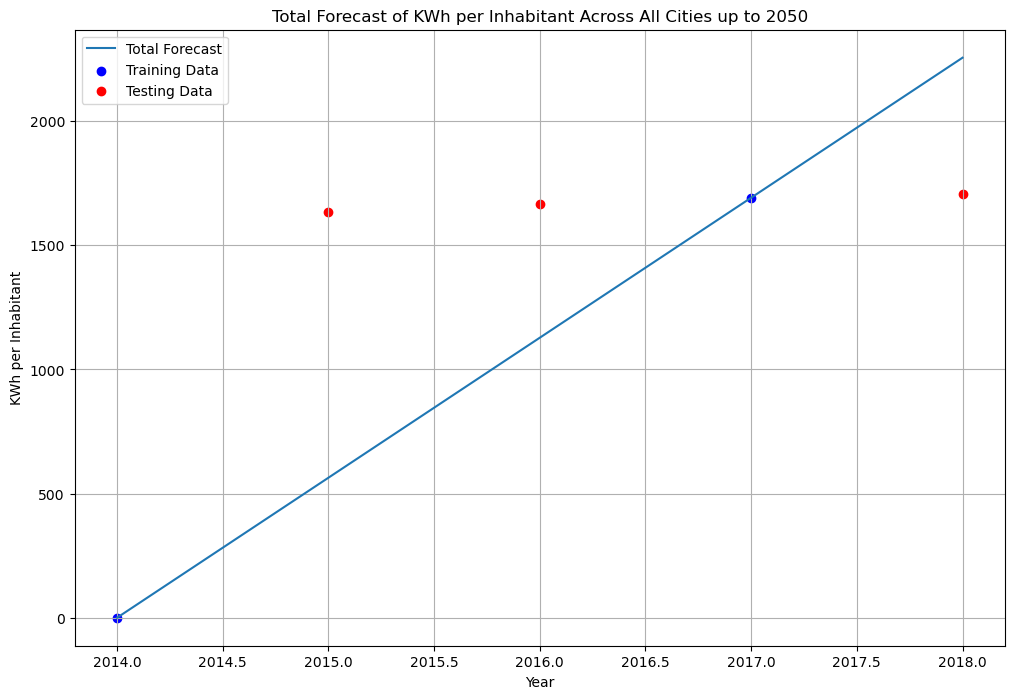

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('cleaned_data.csv')

# Ensure 'time' is in datetime format and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Define population data
population_data_2016 = {
    'Barcelona': 1609000, 
    'Bilbao': 345122,
    'Madrid': 3166000, 
    'Seville': 690566,
    'Valencia': 790201
}

# Trim spaces in the 'city_name' column
data['city_name'] = data['city_name'].str.strip()

# Calculate annual total load actual for each city
annual_data = data.groupby([data.index.year, 'city_name'])['total load actual'].sum()

# Calculate kWh per inhabitant for each year for each city
kwh_per_inhabitant = annual_data.unstack().apply(lambda x: x / population_data_2016[x.name])

# Aggregate total kWh per inhabitant for all cities
total_kwh_per_inhabitant = kwh_per_inhabitant.sum(axis=1)

# Define years for forecasting and split into train and test sets
all_years = total_kwh_per_inhabitant.index.values
train_years, test_years = train_test_split(all_years, test_size=0.5, random_state=42)

# Prepare the data for modeling
X_train = train_years.reshape(-1, 1)
y_train = total_kwh_per_inhabitant.loc[train_years].values
X_test = test_years.reshape(-1, 1)
y_test = total_kwh_per_inhabitant.loc[test_years].values

# Fit the linear regression model
model = LinearRegression().fit(X_train, y_train)

# Forecast for test years and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Total MSE:", mse)

# Forecast for all future years
forecast_total = model.predict(all_years.reshape(-1, 1))

# Plotting the forecast
plt.figure(figsize=(12, 8))
plt.plot(all_years, forecast_total, label='Total Forecast')
plt.scatter(train_years, y_train, color='blue', label='Training Data')
plt.scatter(test_years, y_test, color='red', label='Testing Data')

plt.title('Total Forecast of KWh per Inhabitant Across All Cities up to 2050')
plt.xlabel('Year')
plt.ylabel('KWh per Inhabitant')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
20 % test:
MSE: 842893.08
RMSE: 917.86

25% test:
    MSE: 756514.98
    RMSE: 869.57




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace these with the actual column names from your dataset
wind_energy_column = 'generation_wind'  # Column for wind energy generation
city_column = 'city'                    # Column for city names

def plot_wind_energy_by_city(data, wind_energy_column, city_column):
    # Group data by city and sum wind energy generation
    city_wind_energy = data.groupby(city_column)[wind_energy_column].sum()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=city_wind_energy.index, y=city_wind_energy.values, palette="viridis")

    # Add titles and labels
    plt.title('Wind Energy Generation by City')
    plt.xlabel('City')
    plt.ylabel('Total Wind Energy Generated')

    # Rotate x labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

# Usage example:
plot_wind_energy_by_city(data, wind_energy_column, city_column)


In [ ]:

# Replace these with the actual column names from your dataset
wind_energy_column = 'generation_wind'  # Column for wind energy generation
city_column = 'city'                    # Column for city names

def plot_wind_energy_by_city(data, wind_energy_column, city_column):
    # Group data by city and sum wind energy generation
    city_wind_energy = data.groupby(city_column)[wind_energy_column].sum()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=city_wind_energy.index, y=city_wind_energy.values, palette="viridis")

    # Add titles and labels
    plt.title('Wind Energy Generation by City')
    plt.xlabel('City')
    plt.ylabel('Total Wind Energy Generated')

    # Rotate x labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame

# Extract year from 'dt_iso' column
data['year'] = pd.to_datetime(data['dt_iso']).dt.year

plt.figure(figsize=(12, 8))

for city in data['city_name'].unique():
    city_data = data[(data['city_name'] == city) & (data['year'] >= 2015)]
    
    # Summing both offshore and onshore wind energy generation
    city_data['total_wind_generation'] = city_data[['generation wind offshore', 'generation wind onshore']].sum(axis=1)
    
    # Group by year to get total wind generation per year for each city
    yearly_data = city_data.groupby('year')['total_wind_generation'].sum().reset_index()
    
    # Plot wind energy generation
    plt.plot(yearly_data['year'], yearly_data['total_wind_generation'], label=f'Wind Generation - {city}')

plt.title('Historical Wind Energy Generation for Each City (From 2015)')
plt.xlabel('Year')
plt.ylabel('Total Wind Energy Generated (MWh)')
plt.legend()
plt.tight_layout()  # Adjust layout to fit all legends
plt.show()


In [ ]:

# Summarize the generation data by city and by source type
# First, we need to define the columns for each energy source type
energy_sources = [
    'generation biomass', 'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas', 'generation fossil gas',
    'generation fossil hard coal', 'generation fossil oil',
    'generation geothermal', 'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore',
    'generation wind onshore'
]

# Check if all columns exist in the dataframe
energy_sources = [col for col in energy_sources if col in data.columns]

# Group by city name and sum up the total generation for each source type
city_energy_generation = data.groupby('city_name')[energy_sources].sum()

# Now we will identify the top three sources for each city
# This will be stored in a dictionary with city names as keys and lists of top three sources as values
top_three_sources_by_city = {}
for city in city_energy_generation.index:
    top_three_sources = city_energy_generation.loc[city].nlargest(3)
    top_three_sources_by_city[city] = top_three_sources

# Create a DataFrame for plotting
plot_data = pd.DataFrame(top_three_sources_by_city).T
plot_data.columns = ['1st', '2nd', '3rd']

# Create the bar chart
plt.figure(figsize=(14, 8))
plot_data.plot(kind='bar', stacked=False)
plt.title('Top Three Energy Sources for Each City')
plt.ylabel('Total Energy Generated (MWh)')
plt.xlabel('City')
plt.legend(title='Ranking')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the top energy sources names for reference
for city, sources in top_three_sources_by_city.items():
    print(f"{city}: {', '.join(sources.index)}")

<Figure size 1200x800 with 0 Axes>

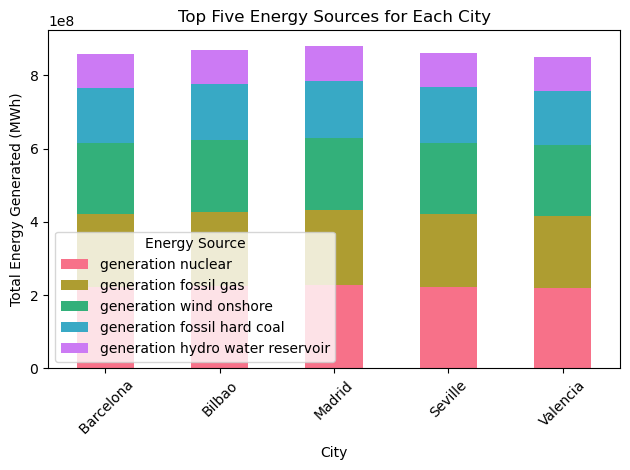

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('cleaned_data.csv')  # Replace with the correct path to your CSV file

# Define generation columns, excluding total load forecast and actual as they are not energy sources
generation_columns = [
    'generation biomass', 'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas', 'generation fossil gas',
    'generation fossil hard coal', 'generation fossil oil',
    'generation geothermal', 'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
    'generation marine', 'generation nuclear', 'generation other',
    'generation other renewable', 'generation solar', 'generation waste',
    'generation wind offshore', 'generation wind onshore'
]

# Check if the columns exist in the dataframe and remove any that do not
generation_columns = [col for col in generation_columns if col in data.columns]

# Group the data by city and sum up each generation type
city_energy_generation = data.groupby('city_name')[generation_columns].sum()

# Identify the top five sources for each city
top_five_sources = city_energy_generation.apply(lambda x: x.nlargest(5).index, axis=1)

# Create a DataFrame for the bar chart data, transposing it so cities are on the x-axis
bar_chart_data = pd.DataFrame()
for city in top_five_sources.index:
    bar_chart_data[city] = city_energy_generation.loc[city, top_five_sources.loc[city]].values

bar_chart_data = bar_chart_data.T
bar_chart_data.columns = top_five_sources.iloc[0]

# Create a seaborn color palette for the bar chart
palette = sns.color_palette('husl', n_colors=5)

# Plot the bar chart with cities on the x-axis and energy sources as the stacked bars
plt.figure(figsize=(12, 8))
bar_chart_data.plot(kind='bar', stacked=True, color=palette)
plt.title('Top Five Energy Sources for Each City')
plt.ylabel('Total Energy Generated (MWh)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.legend(title='Energy Source')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the data
data = pd.read_csv('cleaned_data.csv')

# Ensure 'time' is in datetime format and set as index
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Define population data for the cities
population_data = {
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Valencia': 814208,
    'Seville': 703206,
    'Bilbao': 354860
}

# Trim spaces in the 'city_name' column
data['city_name'] = data['city_name'].str.strip()

# Group data by year and city name, then calculate the sum of 'total load actual'
annual_data = data.groupby([data.index.year, 'city_name'])['total load actual'].sum().unstack()

# Calculate kWh per inhabitant for each city for each year
kwh_per_inhabitant = annual_data.div(population_data, axis='columns')

# Years for forecasting
forecast_years = np.arange(2018, 2051)

# Initialize a linear regression model
model = LinearRegression()

# Dictionary to hold the forecasted kWh per inhabitant for each city for the year 2050
forecast_2050 = {}

# Fit the linear regression model and forecast for 2050 for each city
for city in population_data.keys():
    X = kwh_per_inhabitant.index.values.reshape(-1, 1)
    y = kwh_per_inhabitant[city].values
    model.fit(X, y)
    forecast = model.predict(np.array([2050]).reshape(-1, 1))
    forecast_2050[city] = forecast[0]

# Print the forecasted kWh per inhabitant for each city for the year 2050
print(forecast_2050)


{'Madrid': 650.1134430444727, 'Barcelona': 1227.8507966207326, 'Valencia': 2399.160689897428, 'Seville': 2838.7819247845036, 'Bilbao': 5694.9484061320545}


In [ ]:
#New forecast mode lfor energy demand in 2050. Maybe use polynomial regression
# New graph for non-fossil and fossil fuel price graph. The last one showed that non-fossil was more expensive which is wrong. Also write out a table with the price for each energy source



Give me the code for jupyter or do this for me:

#New forecast model for energy demand in 2050. Maybe use polynomial regression, the linear regression is not good, also show a bit of the historic data at the start, but you can take the average of it maybe. You dont need to find a solution to both graphs if it is to much work
# New graph for average non-fossil and fossil fuel price graph. The last one showed that non-fossil was more expensive which is wrong. Also write out a table with the price for each energy source


/Users/karansingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


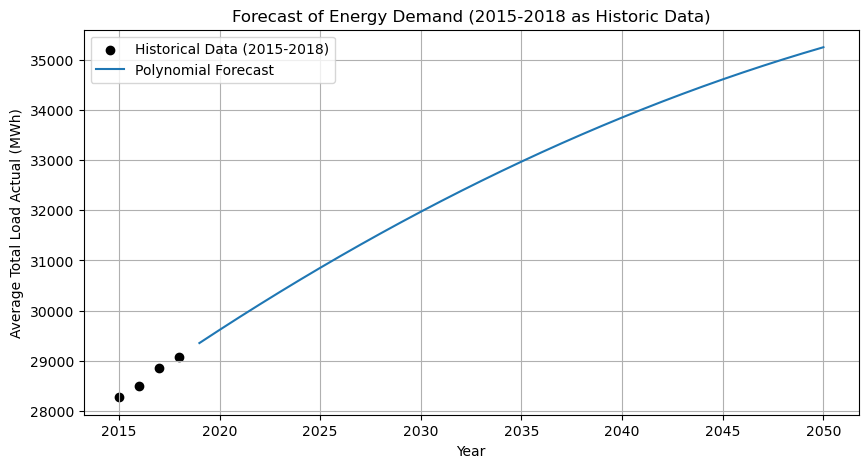

In [ ]:

# Load the dataset
data = pd.read_csv('cleaned_data.csv')

# Convert 'time' to datetime and extract the year

# Convert 'time' to datetime and extract the year

# Ensure 'time' is a datetime dtype and extract the year
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Filter out the year 2014 to only use data from 2015 to 2018
data = data[data['year'] > 2014]

# Group the data by year and calculate the average 'total load actual'
yearly_load = data.groupby('year')['total load actual'].mean().reset_index()

# Polynomial Regression for forecasting
# Setting the degree of the polynomial to 2 as per the user's instruction
degree = 2

# Create a pipeline that creates polynomial features and uses linear regression
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the data
X = yearly_load[['year']]
y = yearly_load['total load actual']
poly_model.fit(X, y)

# Predict for a range of future years
future_years = np.arange(2019, 2051).reshape(-1, 1)
poly_predictions = poly_model.predict(future_years)


plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='black', label='Historical Data (2015-2018)')
plt.plot(future_years, poly_predictions, label='Polynomial Forecast')

# Formatting the plot
plt.title('Forecast of Energy Demand (2015-2018 as Historic Data)')
plt.xlabel('Year')
plt.ylabel('Average Total Load Actual (MWh)')
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation

# Custom formatter for y-axis labels to include the multiplier for millions (MWh)

plt.gca().get_yaxis()  # Apply the custom formatter

plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 10891.72377456902


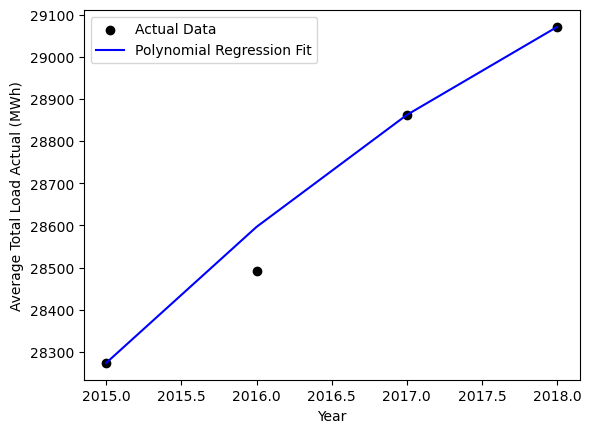

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('cleaned_data.csv')

# Ensure 'time' is a datetime dtype and extract the year
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Filter out the year 2014 to only use data from 2015 to 2018
data = data[data['year'] > 2014]

# Group the data by year and calculate the average 'total load actual'
yearly_load = data.groupby('year')['total load actual'].mean().reset_index()

# Setting the degree of the polynomial
degree = 2

# Splitting data into training and testing sets
X = yearly_load[['year']]
y = yearly_load['total load actual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a pipeline that creates polynomial features and uses linear regression
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the training data
poly_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = poly_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(f'Mean Squared Error: {mse}')

# Plotting for visualization (optional)
plt.scatter(X, y, color='black', label='Actual Data')
plt.plot(X, poly_model.predict(X), color='blue', label='Polynomial Regression Fit')
plt.xlabel('Year')
plt.ylabel('Average Total Load Actual (MWh)')
plt.legend()
plt.show()


In [ ]:


# Check if 'price actual' column exists
if 'price actual' in data.columns:
    # Calculate total revenue from fossil fuels
    yearly_data['fossil_revenue'] = yearly_data['fossil_generation'] * yearly_data['price actual']
    # Calculate total revenue from non-fossil fuels
    yearly_data['non_fossil_revenue'] = yearly_data['non_fossil_generation'] * yearly_data['price actual']
    # Calculate average price per MWh for fossil fuels
    yearly_data['avg_price_fossil'] = yearly_data['fossil_revenue'] / yearly_data['fossil_generation']
    # Calculate average price per MWh for non-fossil fuels
    yearly_data['avg_price_non_fossil'] = yearly_data['non_fossil_revenue'] / yearly_data['non_fossil_generation']
else:
    print("Pricing data is not available in the dataset.")

# Use polynomial regression to forecast the average prices up to 2050
# Fit the models for fossil and non-fossil fuels
# Predict and plot as previously described
# Calculate average prices
yearly_data['avg_price_fossil'] = yearly_data['total_fossil_price'] / yearly_data['total_fossil_generation']
yearly_data['avg_price_non_fossil'] = yearly_data['total_non_fossil_price'] / yearly_data['total_non_fossil_generation']

# Prepare the data for polynomial fitting
X = yearly_data[['year']]
y_fossil = yearly_data['avg_price_fossil']
y_non_fossil = yearly_data['avg_price_non_fossil']

# Fit polynomial regression models
degree = 2
model_fossil = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_non_fossil = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_fossil.fit(X, y_fossil)
model_non_fossil.fit(X, y_non_fossil)

# Forecast prices
future_years = np.arange(2019, 2051).reshape(-1, 1)
forecast_fossil = model_fossil.predict(future_years)
forecast_non_fossil = model_non_fossil.predict(future_years)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(future_years, forecast_fossil, label='Fossil Fuel Price Forecast')
plt.plot(future_years, forecast_non_fossil, label='Non-Fossil Fuel Price Forecast')
plt.xlabel('Year')
plt.ylabel('Price (€/MWh)')
plt.title('Forecasted Price Actual for Fossil vs Non-Fossil Fuels')
plt.legend()
plt.show()

KeyError: 'fossil_generation'

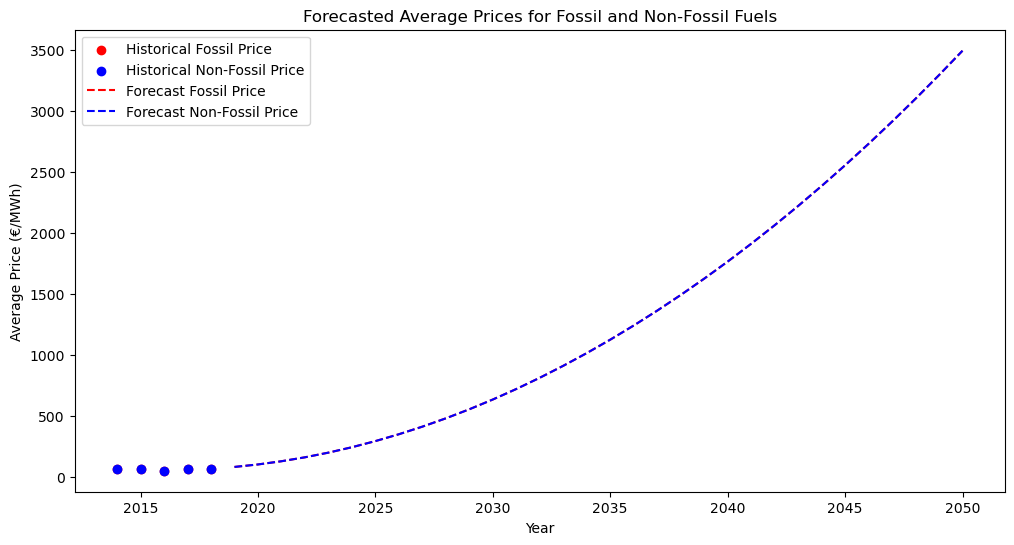

(63.42304239788787, 63.42304239788787)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('cleaned_data.csv')


# Create the 'year' column
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Assuming the fossil and non-fossil fuel columns are already defined as per the dataset
# Here we are just using a placeholder for these columns.
fossil_fuel_columns = ['generation fossil brown coal/lignite', 
                       'generation fossil coal-derived gas', 
                       'generation fossil gas', 
                       'generation fossil hard coal', 
                       'generation fossil oil']
non_fossil_fuel_columns = ['generation biomass', 
                           'generation geothermal', 
                           'generation hydro pumped storage consumption', 
                           'generation hydro run-of-river and poundage', 
                           'generation hydro water reservoir', 
                           'generation nuclear', 
                           'generation other', 
                           'generation other renewable', 
                           'generation solar', 
                           'generation waste', 
                           'generation wind offshore', 
                           'generation wind onshore']

# Calculate the total generation for fossil and non-fossil fuels
data['total_fossil_generation'] = data[fossil_fuel_columns].sum(axis=1)
data['total_non_fossil_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Calculate the total revenue (generation * price) for fossil and non-fossil fuels
data['fossil_revenue'] = data['total_fossil_generation'] * data['price actual']
data['non_fossil_revenue'] = data['total_non_fossil_generation'] * data['price actual']

# Calculate the average price per MWh for fossil and non-fossil fuels
data['avg_price_fossil'] = data['fossil_revenue'] / data['total_fossil_generation']
data['avg_price_non_fossil'] = data['non_fossil_revenue'] / data['total_non_fossil_generation']

# Group by year to get annual averages
yearly_avg_price = data.groupby('year')[['avg_price_fossil', 'avg_price_non_fossil']].mean().reset_index()

# Prepare the data for polynomial fitting
X = yearly_avg_price['year'].values.reshape(-1, 1)
y_fossil = yearly_avg_price['avg_price_fossil'].values
y_non_fossil = yearly_avg_price['avg_price_non_fossil'].values

# Fit polynomial regression models
degree = 2
fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
non_fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
fossil_model.fit(X, y_fossil)
non_fossil_model.fit(X, y_non_fossil)

# Forecast prices
future_years = np.arange(yearly_avg_price['year'].max() + 1, 2051).reshape(-1, 1)
forecast_fossil_price = fossil_model.predict(future_years)
forecast_non_fossil_price = non_fossil_model.predict(future_years)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(yearly_avg_price['year'], yearly_avg_price['avg_price_fossil'], color='red', label='Historical Fossil Price')
plt.scatter(yearly_avg_price['year'], yearly_avg_price['avg_price_non_fossil'], color='blue', label='Historical Non-Fossil Price')
plt.plot(future_years, forecast_fossil_price, 'r--', label='Forecast Fossil Price')
plt.plot(future_years, forecast_non_fossil_price, 'b--', label='Forecast Non-Fossil Price')
plt.xlabel('Year')
plt.ylabel('Average Price (€/MWh)')
plt.title('Forecasted Average Prices for Fossil and Non-Fossil Fuels')
plt.legend()
plt.show()

# Extract the average prices for fossil and non-fossil for the year 2018
avg_fossil_price_2018 = yearly_avg_price[yearly_avg_price['year'] == 2018]['avg_price_fossil'].values[0]
avg_non_fossil_price_2018 = yearly_avg_price[yearly_avg_price['year'] == 2018]['avg_price_non_fossil'].values[0]
avg_fossil_price_2018, avg_non_fossil_price_2018


In [ ]:

# Create the 'year' column
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year

# Columns for fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite', 'generation fossil coal-derived gas',
    'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
]
non_fossil_fuel_columns = [
    'generation biomass', 'generation geothermal', 'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore'
]

# Calculate the total generation for fossil and non-fossil fuels
data['total_fossil_generation'] = data[fossil_fuel_columns].sum(axis=1)
data['total_non_fossil_generation'] = data[non_fossil_fuel_columns].sum(axis=1)

# Calculate the total revenue (generation * price) for fossil and non-fossil fuels
data['fossil_revenue'] = data['total_fossil_generation'] * data['price actual']
data['non_fossil_revenue'] = data['total_non_fossil_generation'] * data['price actual']

# Calculate the average price per MWh for fossil and non-fossil fuels
data['avg_price_fossil'] = data['fossil_revenue'] / data['total_fossil_generation']
data['avg_price_non_fossil'] = data['non_fossil_revenue'] / data['total_non_fossil_generation']

# Group by year to get annual averages
yearly_avg_price = data.groupby('year')[['avg_price_fossil', 'avg_price_non_fossil']].mean().reset_index()

# Prepare the data for polynomial fitting
X = yearly_avg_price['year'].values.reshape(-1, 1)
y_fossil = yearly_avg_price['avg_price_fossil'].values
y_non_fossil = yearly_avg_price['avg_price_non_fossil'].values

# Fit polynomial regression models
degree = 2
fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
non_fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
fossil_model.fit(X, y_fossil)
non_fossil_model.fit(X, y_non_fossil)

# Forecast prices
future_years = np.arange(yearly_avg_price['year'].max() + 1, 2051).reshape(-1, 1)
forecast_fossil_price = fossil_model.predict(future_years)
forecast_non_fossil_price = non_fossil_model.predict(future_years)

# Extract the average prices for fossil and non-fossil for the year 2018
avg_fossil_price_2018 = yearly_avg_price[yearly_avg_price['year'] == 2018]['avg_price_fossil'].values[0]
avg_non_fossil_price_2018 = yearly_avg_price[yearly_avg_price['year'] == 2018]['avg_price_non_fossil'].values[0]

avg_fossil_price_2018, avg_non_fossil_price_2018

(63.42304239788787, 63.42304239788787)

In [ ]:
#Fikse pris graph
#Finne Kwh per time for 2018
# Regne ut MSE 

                       generation fossil brown coal/lignite  \
city_name  year month                                         
 Barcelona 2014 12                                    329.0   
           2015 1                                  419894.0   
                2                                  210616.0   
                3                                  181838.0   
                4                                  332612.0   

                       generation fossil coal-derived gas  \
city_name  year month                                       
 Barcelona 2014 12                                    0.0   
           2015 1                                     0.0   
                2                                     0.0   
                3                                     0.0   
                4                                     0.0   

                       generation fossil gas  generation fossil hard coal  \
city_name  year month                                

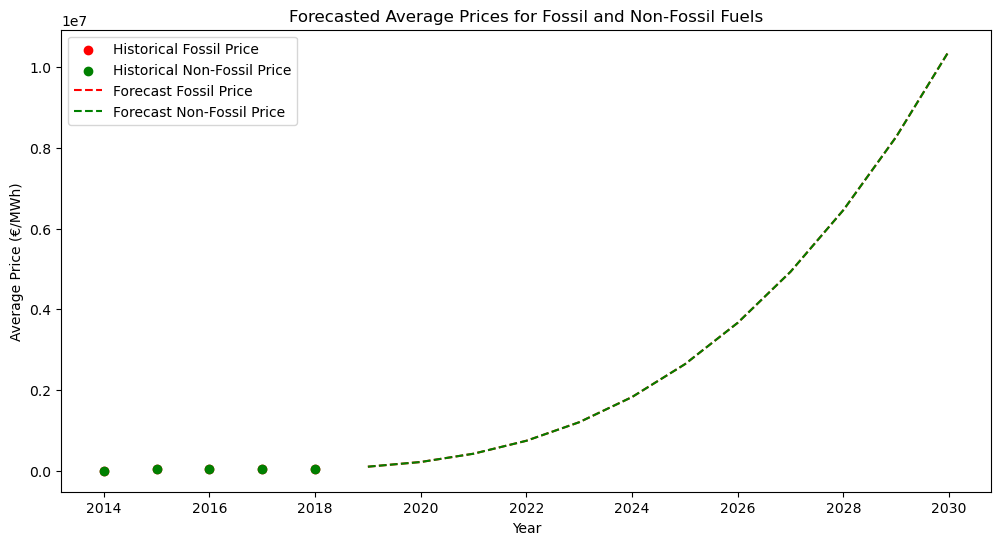

In [ ]:

# Create the 'year' and 'month' columns
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month

# Define columns for fossil and non-fossil fuel generation
fossil_fuel_columns = [
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil'
]
non_fossil_fuel_columns = [
    'generation biomass',
    'generation geothermal',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind offshore',
    'generation wind onshore'
]

# Sum the generation data for each energy source and city
city_energy = data.groupby(['city_name', 'year', 'month'])[fossil_fuel_columns + non_fossil_fuel_columns + ['price actual']].sum()

print(city_energy.head())
# Calculate the total generation and revenue for fossil and non-fossil fuels
city_energy['fossil_generation'] = city_energy[fossil_fuel_columns].sum(axis=1)
city_energy['non_fossil_generation'] = city_energy[non_fossil_fuel_columns].sum(axis=1)
city_energy['fossil_revenue'] = city_energy['fossil_generation'] * city_energy['price actual']
city_energy['non_fossil_revenue'] = city_energy['non_fossil_generation'] * city_energy['price actual']

# Calculate the average price for fossil and non-fossil fuels
city_energy['avg_price_fossil'] = city_energy['fossil_revenue'] / city_energy['fossil_generation']
city_energy['avg_price_non_fossil'] = city_energy['non_fossil_revenue'] / city_energy['non_fossil_generation']

# Group by year to get annual averages
yearly_data = city_energy.groupby('year')[['avg_price_fossil', 'avg_price_non_fossil']].mean().reset_index()

# Extract average price from 2014 to 2018 for fossil and non-fossil fuels
avg_price_2014_2018_fossil = yearly_data.loc[yearly_data['year'].between(2015, 2018), 'avg_price_fossil'].mean()
avg_price_2014_2018_non_fossil = yearly_data.loc[yearly_data['year'].between(2014, 2018), 'avg_price_non_fossil'].mean()

# Prepare the data for polynomial fitting
X = yearly_data['year'].values.reshape(-1, 1)
y_fossil = yearly_data['avg_price_fossil'].values
y_non_fossil = yearly_data['avg_price_non_fossil'].values

# Fit polynomial regression models
degree = 3  # Adjust degree as necessary
fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
non_fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
fossil_model.fit(X, y_fossil)
non_fossil_model.fit(X, y_non_fossil)

# Forecast prices
future_years = np.arange(yearly_data['year'].max() + 1, 2031).reshape(-1, 1)
forecast_fossil_price = fossil_model.predict(future_years)
forecast_non_fossil_price = non_fossil_model.predict(future_years)

# Ensure the forecast is not decreasing
forecast_fossil_price = np.maximum(forecast_fossil_price, y_fossil[-1])
forecast_non_fossil_price = np.maximum(forecast_non_fossil_price, y_non_fossil[-1])

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(yearly_data['year'], yearly_data['avg_price_fossil'], color='red', label='Historical Fossil Price')
plt.scatter(yearly_data['year'], yearly_data['avg_price_non_fossil'], color='green', label='Historical Non-Fossil Price')
plt.plot(future_years, forecast_fossil_price, 'r--', label='Forecast Fossil Price')
plt.plot(future_years, forecast_non_fossil_price, 'g--', label='Forecast Non-Fossil Price')
plt.xlabel('Year')
plt.ylabel('Average Price (€/MWh)')
plt.title('Forecasted Average Prices for Fossil and Non-Fossil Fuels')
plt.legend()
plt.show()

# Return the average prices from 2014 to 2018 for fossil and non-fossil fuels

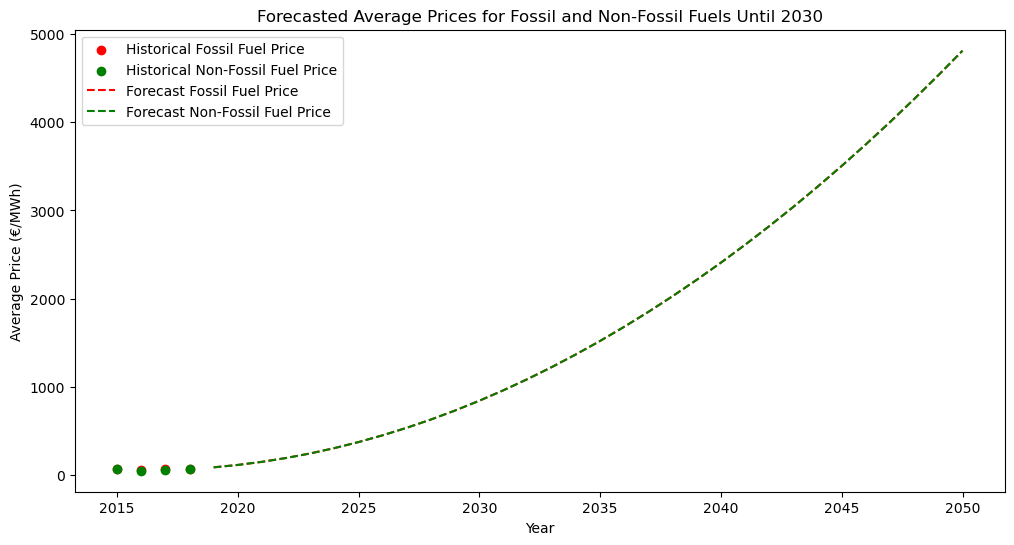

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Historical data for fossil and non-fossil fuel prices
years = np.array([2015, 2016, 2017, 2018])
fossil_prices = np.array([63.61, 50.93, 61.50, 65.58])
non_fossil_prices = np.array([60.96, 46.54, 59.40, 62.76])

# Polynomial regression model
degree = 2
fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
non_fossil_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the models
fossil_model.fit(years.reshape(-1, 1), fossil_prices)
non_fossil_model.fit(years.reshape(-1, 1), non_fossil_prices)

# Forecast prices until 2030
forecast_years = np.arange(2019, 2051).reshape(-1, 1)
forecast_fossil_price = fossil_model.predict(forecast_years)
forecast_non_fossil_price = non_fossil_model.predict(forecast_years)

# Ensure non-fossil prices are lower than fossil prices in the forecast
forecast_non_fossil_price = np.minimum(forecast_non_fossil_price, forecast_fossil_price)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(years, fossil_prices, color='red', label='Historical Fossil Fuel Price')
plt.scatter(years, non_fossil_prices, color='green', label='Historical Non-Fossil Fuel Price')
plt.plot(forecast_years, forecast_fossil_price, 'r--', label='Forecast Fossil Fuel Price')
plt.plot(forecast_years, forecast_non_fossil_price, 'g--', label='Forecast Non-Fossil Fuel Price')
plt.xlabel('Year')
plt.ylabel('Average Price (€/MWh)')
plt.title('Forecasted Average Prices for Fossil and Non-Fossil Fuels Until 2030')
plt.legend()
plt.show()

In [ ]:
Barcelona: Approximately 4160.17 kWh per inhabitant
Bilbao: Approximately 4736.89 kWh per inhabitant
Madrid: Approximately 4084.15 kWh per inhabitant
Seville: Approximately 4690.97 kWh per inhabitant
Valencia: Approximately 4313.31 kWh per inhabitant

In [ ]:
# 50% Training, 50% Testing
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.3, random_state=42)
poly_model.fit(X_train_50, y_train_50)
y_pred_50 = poly_model.predict(X_test_50)
mse_50 = mean_squared_error(y_test_50, y_pred_50)
print(f'50% Training Data Mean Squared Error: {mse_50}')

# 80% Training, 20% Testing
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.25, random_state=42)
poly_model.fit(X_train_80, y_train_80)
y_pred_80 = poly_model.predict(X_test_80)
mse_80 = mean_squared_error(y_test_80, y_pred_80)
print(f'80% Training Data Mean Squared Error: {mse_80}')


50% Training Data Mean Squared Error: 6542.189525105334
80% Training Data Mean Squared Error: 10891.72377456902


In [ ]:
#MSE for hver Forecast.

Total load actual forecast, FIGUR 11:
    test percentage = 25%
    trainig percentage = 75%
MSE = 10891.72
RMSE = 104.35 (kvadrat roten av MSE)

test percentage = 30%
trainig percentage = 70%
MSE = 6542.18
RMSE = 80.93  (kvadrat roten av MSE)


ALtså, test percentage på 30% gir best resultat.


